In [1]:
#
import numpy as np
import os, sys

#
sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag, cut, get_tractor
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, get_svfields_fg, get_svfields_ij, get_svfields_k, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin, plot_venn2
from postages_images import postages_circle

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import glob

from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table, Column, vstack

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

#
sys.path.insert(0, '/global/homes/q/qmxp55/DESI/ls_postages')
from main import html_postages

import bokeh.plotting as bk
from bokeh.models import Tabs
from bokeh.io import show


# set up

In [2]:
ran = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9m/dr9m_random_N3.npy', mmap_mode='r+')

In [3]:
def svfields(survey=None):
    
    svfields_n = {}
    svfields_s = {}
    
    #north
    svfields_n['egs'] = [210, 220, 50, 55] #31
    svfields_n['refnorth'] = [215, 230, 41, 46] #56
    svfields_n['highebv_n'] = [140, 150, 65, 70] #19
    svfields_n['highstardens_ne'] = [273, 283, 40, 45] #37
    svfields_n['highstardens_nw'] = [120, 130, 40, 60] #37
    svfields_n['lowstardens_n'] = [160, 180, 50, 60] #37

    #south
    svfields_s['g09'] = [129, 141, -2.0, 3.0] #60
    svfields_s['g12'] = [174, 186, -3.0, 2.0] #60
    svfields_s['g15'] = [211, 224, -2.0, 3.0] #65
    svfields_s['sagittarius'] = [200, 210, 5, 10] #49
    svfields_s['lowstardens_s'] = [160, 180, 10, 20] #37

    if survey == 'north':
        return svfields_n
    if survey == 'south':
        return svfields_s
    if survey == None:
        return {**svfields_s, **svfields_n}

svfields = svfields()
#print(list(svfields.keys()))

Text(0, 0.5, 'Dec.')

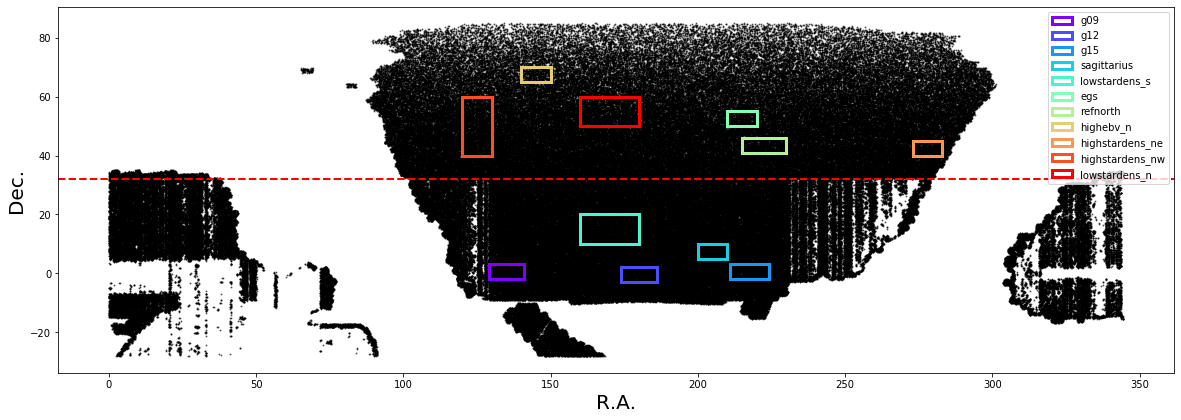

In [5]:
#
import matplotlib.patches as patches
from matplotlib.pyplot import cm

color=cm.rainbow(np.linspace(0,1,len(svfields.keys())))

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, aspect='equal')
plt.scatter(ran['RA'][::500], ran['DEC'][::500], s=1, color='k', alpha=0.5)
plt.axhline(32, lw=2, ls='--', color='r')

for key, val, c in zip(svfields.keys(), svfields.values(), color):
    
    xi, yi = val[0], val[2]
    dx, dy = np.abs(val[1] - val[0]), np.abs(val[3] - val[2])
    
    # Create a Rectangle patch
    rect = patches.Rectangle((xi, yi),dx,dy, linewidth=3, edgecolor=c, facecolor='none', label=key)
    #facecolor='orange' edgecolor='green'

    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.legend()
plt.xlabel(r'R.A.', size=20)
plt.ylabel(r'Dec.', size=20)


### Use code below to extract sources from TRACTOR
```python
#get tractor files
if True:
    
     #
    dr = 'dr9m'
    survey = 'south'
    
    if dr == 'dr8':
        cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                        'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                            'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                                'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                                     'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'TYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                           'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'SHAPEDEV_R', 'SHAPEDEV_R_IVAR',
                                               'SHAPEEXP_R', 'SHAPEEXP_R_IVAR', 'RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'BRICK_PRIMARY']
    elif dr == 'dr9m':
        cols = ['RA', 'DEC', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'FIBERFLUX_R', 'MW_TRANSMISSION_R', 
                    'MW_TRANSMISSION_G', 'MW_TRANSMISSION_Z','MASKBITS', 'REF_CAT', 'REF_ID', 
                        'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE', 'FRACFLUX_G', 
                            'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z',
                                 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'TYPE', 'FLUX_IVAR_R', 'FLUX_IVAR_G',
                                       'FLUX_IVAR_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'SHAPE_R', 'SHAPE_R_IVAR',
                                           'SHAPE_E1', 'SHAPE_E1_IVAR', 'SHAPE_E2', 'SHAPE_E2_IVAR', 'SERSIC', 'SERSIC_IVAR',
                                               'RELEASE', 'BRICKID', 'BRICKNAME', 'OBJID', 'BRICK_PRIMARY', 'FITBITS']

   
    
    #tractor_path = '/global/cscratch1/sd/ziyaoz/dr9m/south/tractor/'
    tractor_path = '/global/cfs/cdirs/cosmo/work/legacysurvey/%s/%s/tractor/' %(dr, survey)
    outdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/tractor/%s_r21_footprint.npy' %(dr, survey)
    patches = svfields(survey=survey)
    cat = get_tractor(tractor_path=tractor_path, patches=patches, outdir=outdir, rlimit=21.0, opt='1', cols=cols)

    #
    outdirBGS = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/tractor/%s_r21_footprint_bgsbits.npy' %(dr, survey)
    catBGS = getBGSbits(mycatpath=outdir, outdir=outdirBGS, mycat=True, getmycat=True, tractor=True)
```

In [4]:
#
dr = 'dr9m'
survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'svfields_k'
#reg = 'svfields_ij'
#reg = 'svfields'
#reg = 'south'
dec_resol_ns = 32.375
if (dr[:3] == 'dr9'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/tractor-%s-%s_%s_%s_draft_plots' %(dr, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)
    
if reg[:8] == 'svfields': desifootprint = False
else: desifootprint = True

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr          = fits.getheader(dr8pix,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

dr9k fields footprint selected
dr9k fields footprint selected
dr9k fields footprint selected


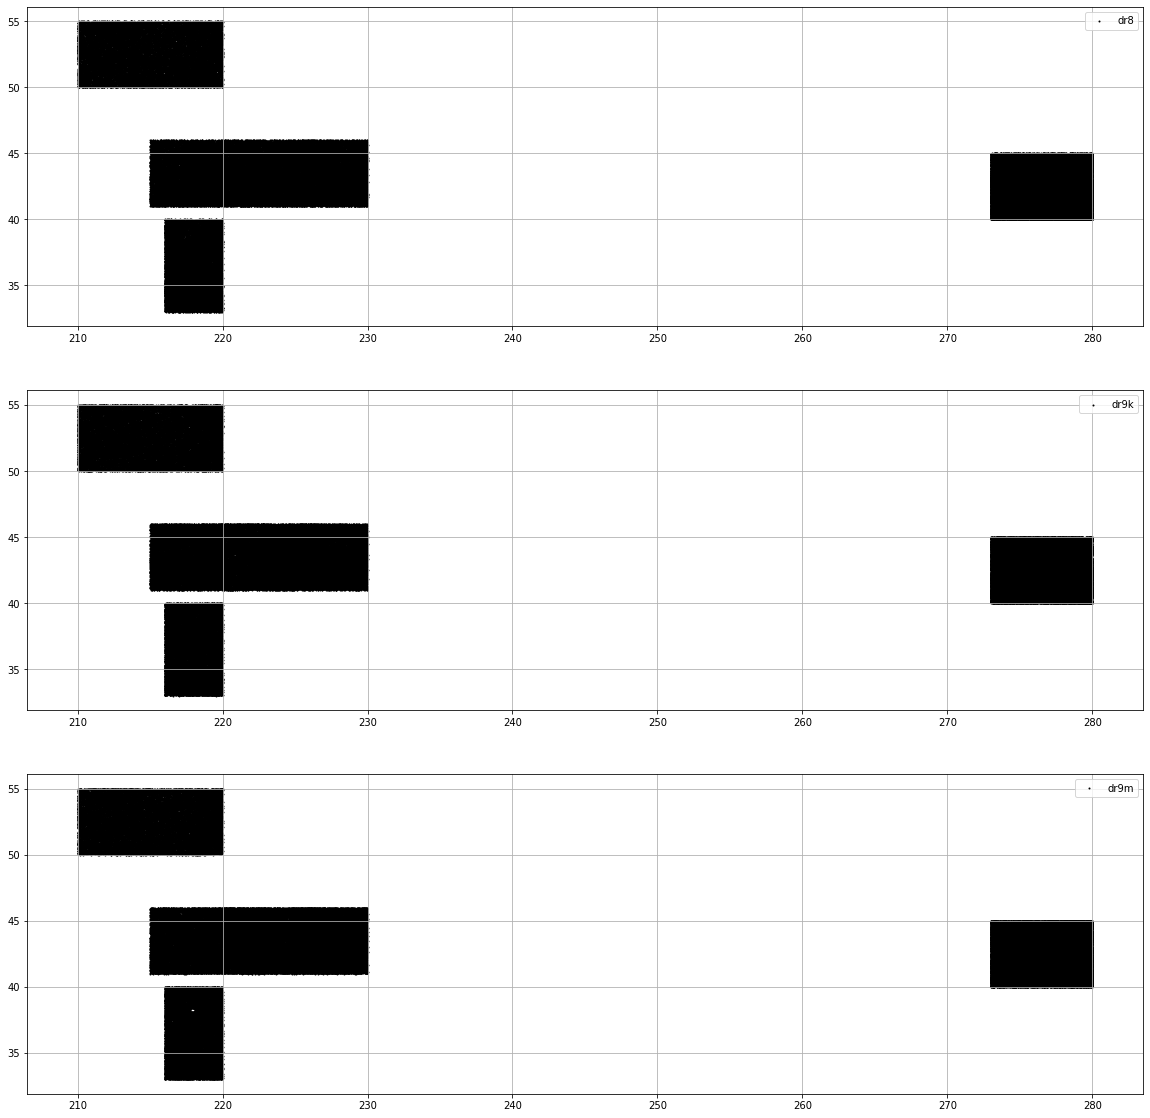

In [5]:
#
cats = {}

survey = 'south'
reg = 'custom_svfields'

pathdir = os.path.abspath(os.getcwd())+'/tractor-%s_%s' %(survey, reg)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

plt.figure(figsize=(20, 20))

for num, dr in enumerate(['dr8', 'dr9k', 'dr9m']):
    
    if dr == 'dr9m':
        cat = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/tractor/%s_r21_k_footprint_bgsbits.npy' %(dr, survey))
    elif dr == 'dr9k':
        filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
        version = '0.1.0'
        cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets-'+survey+'.npy')
    elif dr == 'dr8':
        cat = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/tractor/%s_r21_k_footprint_bgsbits.npy' %(dr, survey))

    #filter by region
    if (reg == 'svfields_k'):

        print('dr9k fields footprint selected')
        catinreg = get_svfields_k(cat['RA'], cat['DEC'], survey=survey)
        if survey == 'south': Area = 176
        elif survey == 'north': Area = 133

    else:
        raise ValueError('Only Svfields k region supported')

    cat = cat[catinreg]
    cats[dr] = cat

    if True:
        
        plt.subplot(3, 1, num+1)
        plt.scatter(cat['RA'][::10], cat['DEC'][::10], s=1, c='k', label=dr)
        plt.grid()
        plt.legend()


# BGS outline

In [6]:
#
for key, cat in zip(cats.keys(), cats.values()):
    
    print('============== RESULTS for %s ==============' %(key))
    
    bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
    bgs_b = ((cat['BGSBITS'] & 2**(21)) != 0)
    bgs_f = ((cat['BGSBITS'] & 2**(22)) != 0)

    print('No BGS galaxies in Bright and Faint and overall: \t %i \t %i \t %i' %(
        np.sum(bgs_b),
        np.sum(bgs_f),
        np.sum(bgs_any)
    ))

    print('Overall BGS densities in Bright and Faint and overall: \t %i \t %i \t %i' %(
        np.round(np.sum(bgs_b)/Area, 0),
        np.round(np.sum(bgs_f)/Area, 0),
        np.round(np.sum(bgs_any)/Area, 0)
    ))

    print('morph \t BRIGHT \t FAINT \t OVERALL')
    print('------------------------------------')
    for morph in list(set(cat['TYPE'][:10000])):

        keep = cat['TYPE'] == morph
        print('%s \t %d \t %d \t %d' %(
            morph, 
            np.round(np.sum((keep) & (bgs_b))/Area, 0),
            np.round(np.sum((keep) & (bgs_f))/Area, 0),
            np.round(np.sum((keep) & (bgs_any))/Area, 0),
            ))


============== RESULTS for dr8 ==============
No BGS galaxies in Bright and Faint and overall: 	 103320 	 74442 	 177762
Overall BGS densities in Bright and Faint and overall: 	 777 	 560 	 1337
morph 	 BRIGHT 	 FAINT 	 OVERALL
------------------------------------
EXP  	 238 	 199 	 437
COMP 	 22 	 2 	 24
REX  	 98 	 140 	 238
PSF  	 3 	 2 	 5
DEV  	 417 	 217 	 633
============== RESULTS for dr9k ==============
No BGS galaxies in Bright and Faint and overall: 	 103359 	 75098 	 178457
Overall BGS densities in Bright and Faint and overall: 	 777 	 565 	 1342
morph 	 BRIGHT 	 FAINT 	 OVERALL
------------------------------------
SER 	 459 	 153 	 612
DEV 	 138 	 143 	 280
REX 	 108 	 151 	 258
EXP 	 72 	 117 	 188
PSF 	 2 	 1 	 3
============== RESULTS for dr9m ==============
No BGS galaxies in Bright and Faint and overall: 	 102680 	 74299 	 176979
Overall BGS densities in Bright and Faint and overall: 	 772 	 559 	 1331
morph 	 BRIGHT 	 FAINT 	 OVERALL
---------------------------------

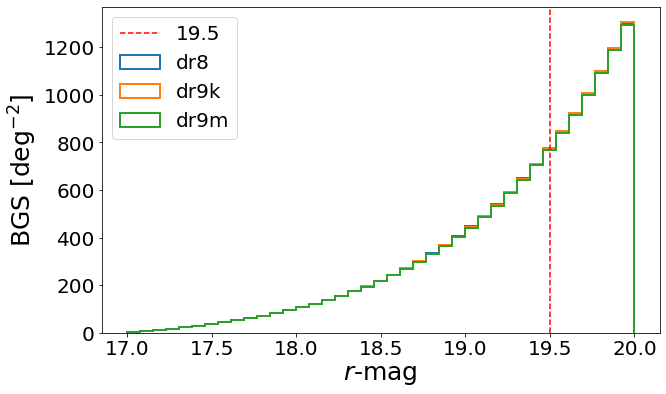

In [7]:
#
fig = plt.figure(figsize=(10,6))

for key, cat in zip(cats.keys(), cats.values()):
    
    rbins = np.linspace(17, 20, 40)
    bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
    plt.hist(cat['RMAG'][bgs_any], bins=rbins, histtype='step', lw=2, cumulative=True, weights=np.full(np.sum(bgs_any), 1/Area), label=key)

plt.axvline(19.5, ls='--', c='r', label='19.5')
plt.xlabel(r'$r$-mag', size=25)
plt.ylabel(r'BGS [deg$^{-2}$]', size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left', fontsize=20)
#plt.yscale('log')

plt.show()

file = '%s/number_counts' %(pathdir)
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


In [34]:

#
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(np.round(height, 1)),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(3, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
def get_bars(labels=None, cats=None, Area=None, bgsmask=None, survey=None, log=False, rejects=False, width=None, figsize=(30,10), title=None, mask=None):
        
    #labels = ['BS', 'MS', 'LG', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    rects = {}

    x = np.arange(len(labels))  # the label locations
    if width is None: width = 0.25  # the width of the bars
    delta = 0

    fig, ax = plt.subplots(figsize=figsize)

    for key, cat in zip(cats.keys(), cats.values()):
        
        mask2 = np.ones_like(cat, dtype=bool)
        
        if mask is not None:
            for i in mask:
                mask2 &= ((cat['BGSBITS'] & 2**(bgsmask[i])) != 0)
                #print(np.sum(mask2))

        if rejects: rejs = [np.sum(~((cat['BGSBITS'] & 2**(bgsmask[i])) != 0) & (cat['RMAG'] < 20) & (mask2))/Area for i in labels]
        else: rejs = [np.sum(((cat['BGSBITS'] & 2**(bgsmask[i])) != 0) & (cat['RMAG'] < 20) & (mask2))/Area for i in labels]
        
        #print(rejs)
            
        rects[key] = ax.bar(x - 1*width + delta, rejs, width, label=key)
        delta += width

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('deg$^{-2}$', size=30)
    if title is not None: ax.set_title(title, size=30)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30, rotation=45)
    ax.legend(fontsize=15)
    if log: ax.set_yscale('log')

    for i in rects.keys():
        #autolabel(i)
        #print(i)
        #autolabel(rects[i])
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects[i]:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height, 1)),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(3, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()

    plt.show()

[270.63157894736844, 902.812030075188, 13.31578947368421, 1.300751879699248, 3854.2406015037595, 34.7593984962406, 168.0751879699248, 857.1954887218045, 2.1203007518796992, 74.72932330827068]
[141.62406015037595, 902.4661654135339, 23.353383458646615, 1.255639097744361, 3850.3984962406016, 15.80451127819549, 66.10526315789474, 914.3984962406015, 3.473684210526316, 49.82706766917293]
[149.89473684210526, 942.0601503759399, 24.278195488721803, 1.2781954887218046, 3853.3383458646617, 33.96992481203007, 81.43609022556392, 914.3007518796992, 3.857142857142857, 66.7593984962406]


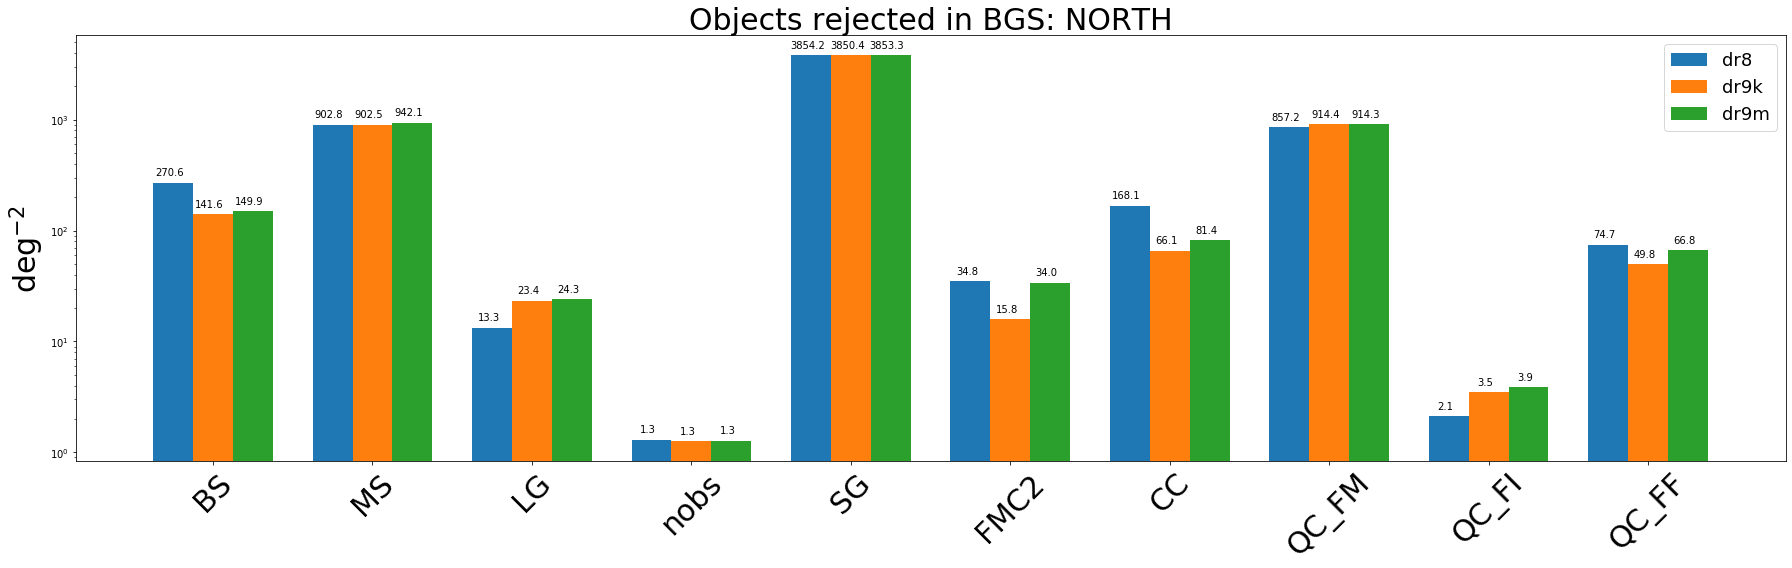

In [31]:
#
labels = ['BS', 'MS', 'LG', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
get_bars(labels=labels, cats=cats, Area=Area, bgsmask=bgsmask(), survey=survey, log=True, rejects=True, title='Objects rejected in BGS: %s' %(survey.upper()), mask=None, figsize=(25,8))

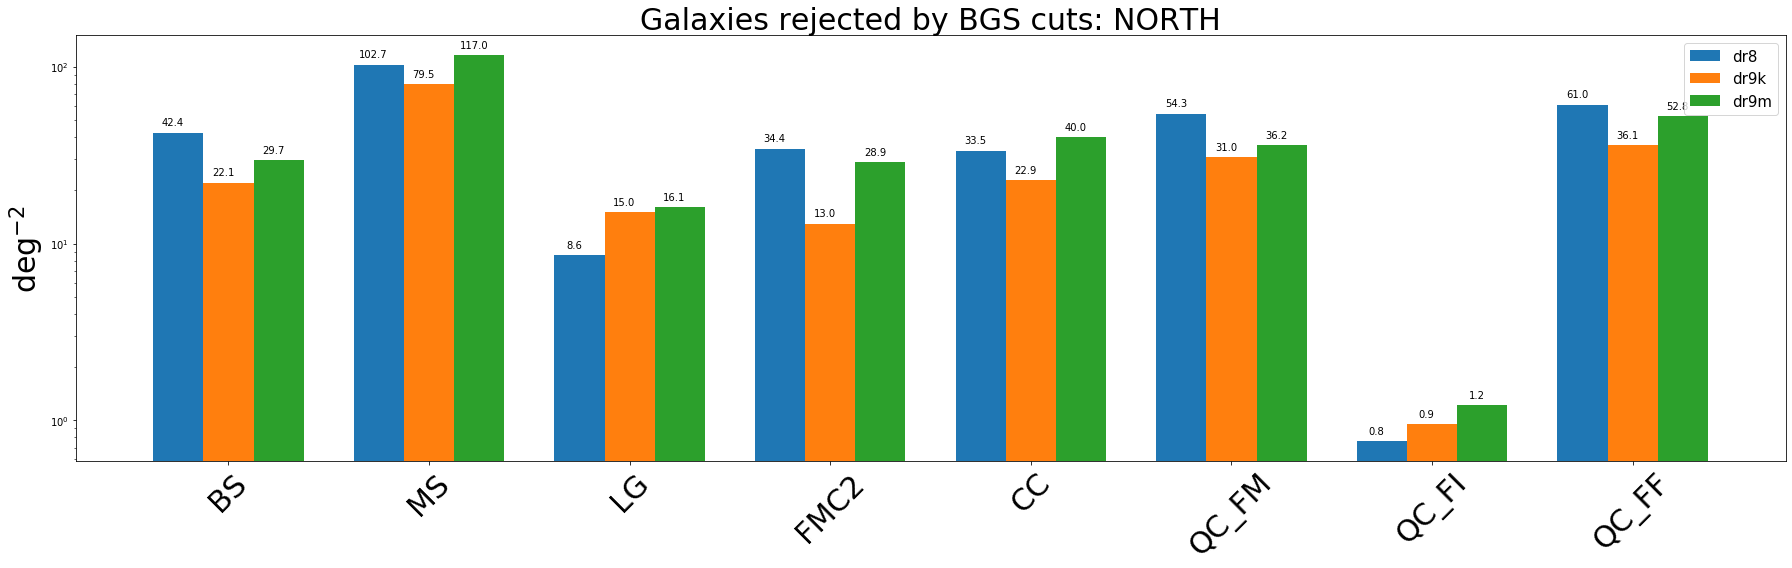

In [36]:
#
labels = ['BS', 'MS', 'LG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
get_bars(labels=labels, cats=cats, Area=Area, bgsmask=bgsmask(), survey=survey, log=True, rejects=True, title='Galaxies rejected by BGS cuts: %s' %(survey.upper()), mask=['SG', 'nobs'], figsize=(25,8))

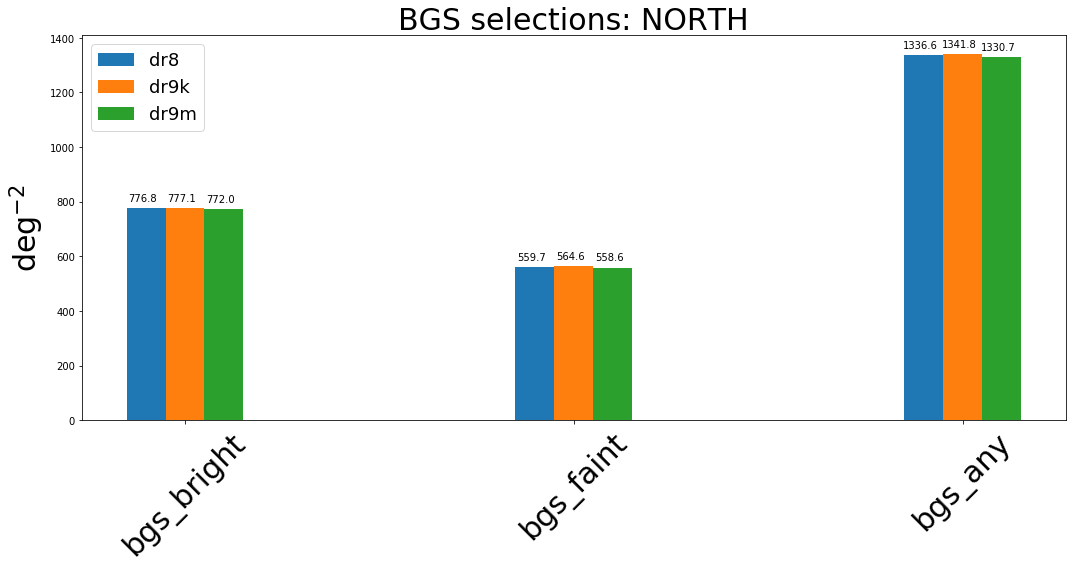

In [101]:
#
labels = ['bgs_bright', 'bgs_faint', 'bgs_any']
get_bars(labels=labels, cats=cats, Area=Area, bgsmask=bgsmask(), survey=survey, width=0.1, figsize=(15,8), title='BGS selections: %s' %(survey.upper()))

# Contamination around Bright Stars and Medium Stars

First we do the stacking around the bright stars (`BS mask`) using BGS but `BS`. 

For the second stacking, we use BGS and do the stacking around the Medium Stars (`MS mask`).

mag_bins_len: 1
5.00 < MAG < 13.00
MARK #1
MARK #2
mag_radii MAX: 110.00796871418599 mag_radii MIN: 10.678721880460714
mag MAX: 12.999948501586914 mag MIN: 5.363476753234863
d2d min=0.127, d2d max=93.6
179819 179819 179819
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.43, 0.588)
8 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 2.18736
----------------


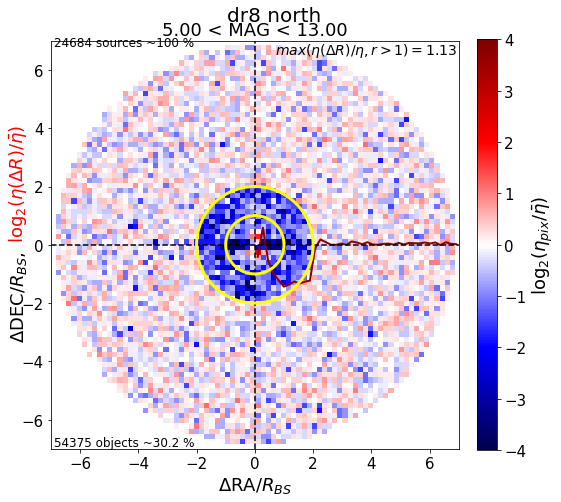

mag_bins_len: 1
5.00 < MAG < 13.00
MARK #1
MARK #2
mag_radii MAX: 110.00796871418599 mag_radii MIN: 10.678721880460714
mag MAX: 12.999948501586914 mag MIN: 5.363476753234863
d2d min=0.106, d2d max=93.6
179018 179018 179018
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.63, 0.233)
11 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 2.23268
----------------


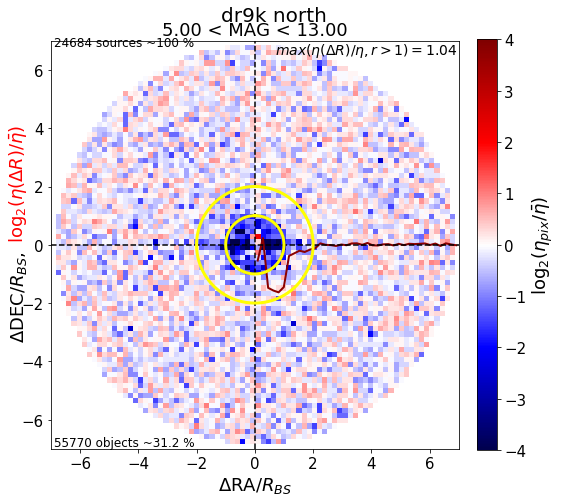

mag_bins_len: 1
5.00 < MAG < 13.00
MARK #1
MARK #2
mag_radii MAX: 110.00796871418599 mag_radii MIN: 10.678721880460714
mag MAX: 12.999948501586914 mag MIN: 5.363476753234863
d2d min=0.11, d2d max=93.6
178157 178157 178157
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-1.2, 2.24)
7 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 4.58494
----------------


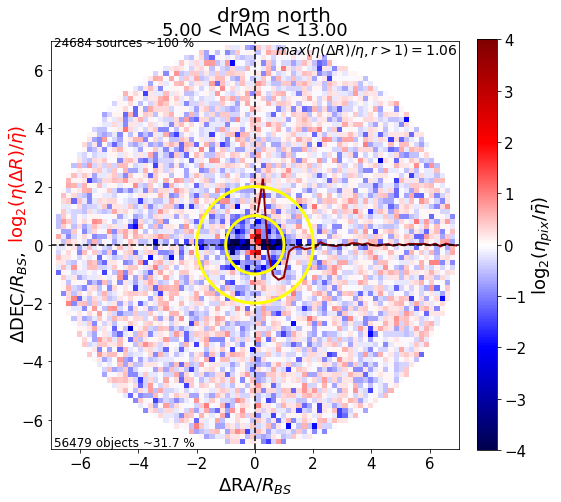

In [111]:
#star catalogue
stars = np.load('/global/cscratch1/sd/qmxp55/pauline/stars_GAIA_TYCHO_13.npy')
if reg == 'svfields_k': starsinreg = get_svfields_k(stars['RA'], stars['DEC'], survey=survey)
else: raise ValueError('Only svfields k footprint is allowd.')
stars = stars[(starsinreg)]

              
#Dustin_radii's
mag = np.linspace(0, 20, 50)
BS_radii = []
new_BS_radii = []
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
              
for i, key, cat in zip(range(len(cats.keys())), cats.keys(), cats.values()):
    
    bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
    bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
    
    log = True
    nbins = 81
    
    plt.figure(figsize=(8,8))
    plt.title(r'%s %s' %(key, survey), size=20)
    plt.axis('off')
    
    d2d2, d_ra2, d_dec2, annMask = overdensity(cat[bgsbutBS], stars, new_BS_radii, 'MAG', 35, density=False, 
                            magbins=[5,13], radii_2=None, grid=[1,1], SR=[0., 1000.], scaling=True, nbins=nbins, 
                                   SR_scaling=7,logDenRat=[-4, 4], radii_bestfit=False, annulus=[1.0, 2.0], bintype='0', 
                                       filename='%s/2d_stack_BS_%s_%s_%s_1_1.5' %(pathdir, dr, survey, key), log=log)
    plt.show()
    
    
            

In [115]:
#
from QA import circular_mask_radii_func
from io_ import query_catalog_mask

for i, key, cat in zip(range(len(cats.keys())), cats.keys(), cats.values()):
    
    print('================= RESULTS %s =================' %(key))
    BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                                 length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    #
    new_BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                                 length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    #masking radius for each object cloosest stars in cat
    mask_radii = circular_mask_radii_func(BS_t[1]['w1_source'], BS_radii, bestfit=False)
    #masking radius reescaled for each object
    mask_radii_res = BS_t[1]['d2d_source']/mask_radii
    #
    BS_diff = (BS_t[0]) & (~new_BS_t[0]) & (cat['RMAG'] < 20)
    bgsbutBS = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
    PSF = ((cat['TYPE'] == 'PSF') | (cat['TYPE'] == 'PSF ')) 
    refcat = cat['REF_CAT']
    if isinstance(np.atleast_1d(refcat)[0], str):
        LG = [(rc[0] == "L") if len(rc) > 0 else False for rc in refcat]
    else:
        LG = [(rc.decode()[0] == "L") if len(rc) > 0 else False for rc in refcat]

    print('objects within BS radii defs & r<20: \t %i (PSF) \t %i (no-PSF) \t %i (LSLGA)' 
          %(np.sum((BS_diff) & (PSF)), np.sum((BS_diff) & (~PSF)), np.sum((BS_diff) & (LG))))
    print('objects within BS radii defs & r<20 & BGS: \t %i (PSF) \t %i (no-PSF) \t %i (LSLGA)' 
          %(np.sum((BS_diff) & (PSF) & (bgsbutBS)), np.sum((BS_diff) & (~PSF) & (bgsbutBS)), np.sum((BS_diff) & (LG))))


================= RESULTS dr8 =================
Total run time: 3.447758 sec
Total run time: 3.229687 sec
objects within BS radii defs & r<20: 	 16470 (PSF) 	 127 (no-PSF) 	 26 (LSLGA)
objects within BS radii defs & r<20 & BGS: 	 1311 (PSF) 	 18 (no-PSF) 	 26 (LSLGA)
================= RESULTS dr9k =================
Total run time: 3.231837 sec
Total run time: 3.507804 sec
objects within BS radii defs & r<20: 	 14925 (PSF) 	 2957 (no-PSF) 	 26 (LSLGA)
objects within BS radii defs & r<20 & BGS: 	 77 (PSF) 	 2706 (no-PSF) 	 26 (LSLGA)
================= RESULTS dr9m =================
Total run time: 3.436310 sec
Total run time: 3.682062 sec
objects within BS radii defs & r<20: 	 15028 (PSF) 	 4648 (no-PSF) 	 26 (LSLGA)
objects within BS radii defs & r<20 & BGS: 	 94 (PSF) 	 2915 (no-PSF) 	 26 (LSLGA)


$\Delta \vec{r}/r_{BS}$

### Medium BS

25 nearby objects
73798 Medium Bright Stars
CPU times: user 5.48 s, sys: 1.21 s, total: 6.69 s
Wall time: 1.69 s
mag_bins_len: 1
13.00 < MAG < 16.00
MARK #1
MARK #2
mag_radii MAX: 10.678527002237324 mag_radii MIN: 4.272310521494741
mag MAX: 15.999944686889648 mag MIN: 13.000005722045898
d2d min=0.00182, d2d max=117
177762 177762 177762
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.115)
33 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 1.33628
----------------


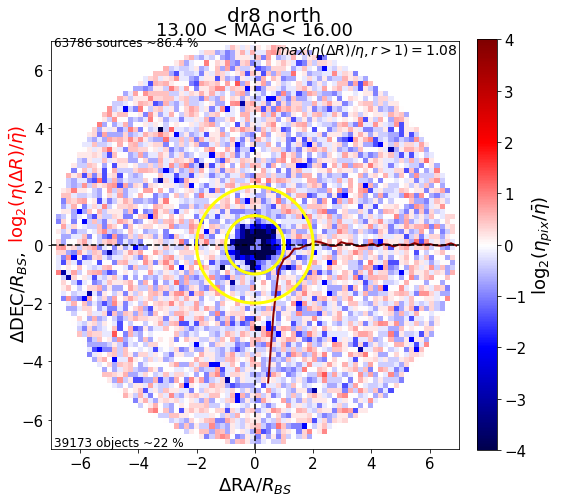

mag_bins_len: 1
13.00 < MAG < 16.00
MARK #1
MARK #2
mag_radii MAX: 10.678527002237324 mag_radii MIN: 4.272310521494741
mag MAX: 15.999944686889648 mag MIN: 13.000005722045898
d2d min=0.00105, d2d max=117
178457 178457 178457
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0926)
28 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 1.23963
----------------


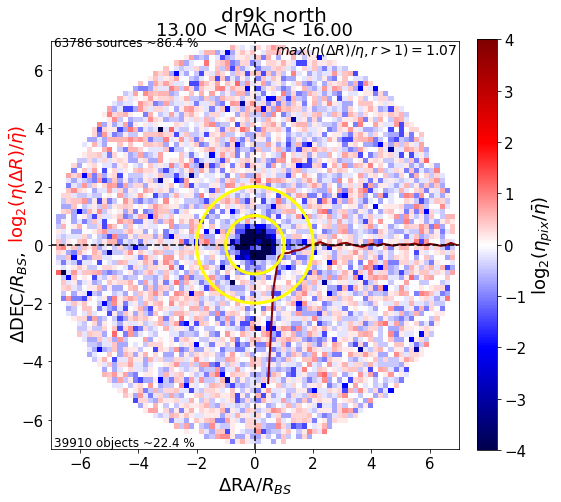

mag_bins_len: 1
13.00 < MAG < 16.00
MARK #1
MARK #2
mag_radii MAX: 10.678527002237324 mag_radii MIN: 4.272310521494741
mag MAX: 15.999944686889648 mag MIN: 13.000005722045898
d2d min=0.00105, d2d max=117
176979 176979 176979
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-inf, 0.0798)
22 of inf in density ratio out of a total of 4792
Minimum density ratio = -4, Maximum density ratio = 1.24221
----------------


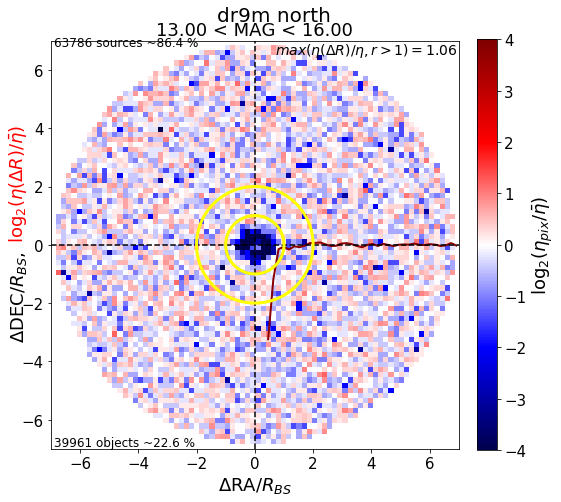

In [116]:
from io_ import get_msmask
from io_ import get_bsmask
from io_ import search_around

#load mask sources objects from SWEEPS DR8
masksources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')
if reg == 'svfields_k': masksourcesinreg = get_svfields_k(masksources['RA'], masksources['DEC'], survey=survey)
else: raise ValueError('Only svfields k footprint is allowd.')
masksources = masksources[(masksourcesinreg)]

#get the medium bright stars
%time starsMS = get_msmask(masksources)
if reg == 'svfields_k': starsMSinreg = get_svfields_k(starsMS['RA'], starsMS['DEC'], survey=survey)
else: raise ValueError('Only svfields k footprint is allowd.')
starsMS = starsMS[(starsMSinreg)]

log = True
nbins = 81

for i, key, cat in zip(range(len(cats.keys())), cats.keys(), cats.values()):
    
    bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
    
    plt.figure(figsize=(8,8))
    plt.title(r'%s %s' %(key, survey), size=20)
    plt.axis('off')

    _ = overdensity(cat[(bgs_any)], starsMS, new_BS_radii, 'MAG', 35, density=False, 
                        magbins=[13,16], radii_2=new_BS_radii, grid=[1,1], SR=[0., 500], scaling=True, nbins=nbins, 
                               SR_scaling=7,logDenRat=[-4, 4], radii_bestfit=False, annulus=[1,2], bintype='0', 
                                   filename='%s/2d_stack_MS_%s_%s_%s' %(pathdir, dr, survey, key), log=log)

    plt.show()


# Direct comparisson between dr9k and dr9m
## Analysis for MS masked objects

In [38]:
cats.pop('dr8')
area = Area

for catname, cat in zip(cats.keys(), cats.values()):
    
    bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #BGS objects
    MS = ((cat['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BS = ((cat['MASKBITS'] & 2**1)!=0) #within BS masking radius
    inMS = (bgs) & (MS) & (~BS)
    outMS = (bgs) & (~MS) & (~BS)
    PSF = cat['TYPE'] == 'PSF'
    
    print('%s-%s: \t %.2f(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS)/area, np.sum(outMS)/area))
    print('\t PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & PSF)/area, np.sum(outMS & PSF)/area))
    print('\t NO-PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & ~PSF)/area, np.sum(outMS & ~PSF)/area))
    

north-dr9k: 	 45.02(inMS) 	 1296.76(outMS)
	 PSF:north-dr9k: 	 0.24/(inMS) 	 2.54(outMS)
	 NO-PSF:north-dr9k: 	 44.78/(inMS) 	 1294.22(outMS)
north-dr9m: 	 48.64(inMS) 	 1282.03(outMS)
	 PSF:north-dr9m: 	 0.24/(inMS) 	 2.48(outMS)
	 NO-PSF:north-dr9m: 	 48.40/(inMS) 	 1279.55(outMS)


In [39]:
#
from io_ import match_coord
cat1, cat2 = cats['dr9k'], cats['dr9m']
if True:
    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat1['RA'], cat1['DEC'], cat2['RA'], cat2['DEC'], search_radius=0.5)
    
    #
    MSf = ((cat1['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSf = ((cat1['MASKBITS'] & 2**1)!=0) #within BS masking radius
    MSg = ((cat2['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSg = ((cat2['MASKBITS'] & 2**1)!=0) #within BS masking radius

    inMSf = (MSf) & (~BSf)
    inMSg = (MSg) & (~BSg)
    outMSf = (~MSf) & (~BSf)
    outMSg = (~MSg) & (~BSg)

Doubly matched objects = 441
Final matched objects = 1242674


In [40]:
#
def create_tab(cat1, cat2, idx1, idx2, cat1name, cat2name):
    
    tabmatch = Table()

    for key in cat1.dtype.names:
    
        tabmatch[key+'_%s' %(cat1name)] = cat1[key][idx1]
        tabmatch[key+'_%s' %(cat2name)] = cat2[key][idx2]
        
    tabmatch['dr9%s' %(cat1name)] = np.ones_like(cat1['RA'][idx1], dtype=bool)
    tabmatch['dr9%s' %(cat2name)] = np.ones_like(cat2['RA'][idx2], dtype=bool)
    
    print('tabmatched DONE...')
    
    tabf = Table()
    
    match_1 = np.zeros_like(cat1['DEC'], dtype=bool)
    match_1[idx1] = True
    df0 = np.ones(np.sum(~match_1), dtype=bool)
    df1 = np.full(np.sum(~match_1), np.nan) #z from gama
    df2 = np.full(np.sum(~match_1), np.nan, dtype=str) #z from gama
    
    for key in cat1.dtype.names:
        
        if isinstance(cat1[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        tabf[key+'_%s' %(cat1name)] = cat1[key][~match_1]
        if key in ['RA', 'DEC']: tabf[key+'_%s' %(cat2name)] = cat1[key][~match_1]
        else: tabf[key+'_%s' %(cat1name)] = df
    
    tabf['dr9%s' %(cat1name)] = df0
    tabf['dr9%s' %(cat2name)] = ~df0
    
    print('tabf DONE...')
    
    tabg = Table()
    
    match_2 = np.zeros_like(cat2['DEC'], dtype=bool)
    match_2[idx2] = True
    df0 = np.ones(np.sum(~match_2), dtype=bool)
    df1 = np.full(np.sum(~match_2), np.nan) #z from gama
    df2 = np.full(np.sum(~match_2), np.nan, dtype=str) #z from gama
    
    for key in cat2.dtype.names:
        
        if isinstance(cat2[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        if key in ['RA', 'DEC']: tabg[key+'_%s' %(cat1name)] = cat2[key][~match_2]
        else: tabg[key+'_%s' %(cat1name)] = df
        tabg[key+'_%s' %(cat2name)] = cat2[key][~match_2]
        
    tabg['dr9%s' %(cat1name)] = ~df0
    tabg['dr9%s' %(cat2name)] = df0
    
    print('tabg DONE...')
    
    tab = vstack([tabmatch, tabf, tabg])
    
    
    '''
    match = (tab['dr9%s' %(cat1name)]) & (tab['dr9%s' %(cat2name)])
    bgsf = ((np.uint64(tab['BGSBITS_%s' %(cat1name)]) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_%s' %(cat2name)]) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum(match)/area))
    
    print('\t & BGS_%s: \t %.3f' %(cat1name, np.sum((bgsf))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((match) & (bgsf) & (bgsg))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((bgsf) & (~bgsg))/area))
    disag = np.sum((bgsf) & (~bgsg))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] < 20))/disag))
    
    
    print('\t & BGS_%s: \t %.3f' %(cat2name, np.sum((bgsg))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((match) & (bgsg) & (bgsf))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((bgsg) & (~bgsf))/area))
    disag = np.sum((bgsg) & (~bgsf))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] < 20))/disag))
    '''
    
    return tab


In [41]:
#
def run2(tab=None, mask=None, cat1name=None, cat2name=None):
    
    if mask is None: mask = np.ones_like(tab, dtype=bool)
        
    match = (tab['dr9%s' %(cat1name)]) & (tab['dr9%s' %(cat2name)])
    bgsf = ((np.uint64(tab['BGSBITS_%s' %(cat1name)]) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_%s' %(cat2name)]) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum((match) & (mask))/area))
    
    print('\t & BGS_%s: \t %.3f' %(cat1name, np.sum((bgsf) & (mask))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat1name, cat2name,np.sum((match) & (bgsf) & (bgsg) & (mask))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((bgsf) & (~bgsg) & (mask))/area))
    disag = np.sum((bgsf) & (~bgsg) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_%s' %(cat2name)] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_%s' %(cat2name)] < 20) & (mask))/disag))
    
    
    print('\t & BGS_%s: \t %.3f' %(cat2name, np.sum((bgsg) & (mask))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((match) & (bgsg) & (bgsf) & (mask))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((bgsg) & (~bgsf) & (mask))/area))
    disag = np.sum((bgsg) & (~bgsf) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_%s' %(cat1name)] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_%s' %(cat1name)] < 20) & (mask))/disag))
 

In [42]:
tab = create_tab(cat1=cat1, cat2=cat2, idx1=idx2, idx2=idx1, cat1name='k', cat2name='m')

tabmatched DONE...
tabf DONE...
tabg DONE...


* All BGS in dr9g within MS
    * & outside BS
* All BGS in dr9f within MS
    * & outside BS
    
* matched & bgsg & ~bgsf & inMSf & inMSg
* matched & bgsg & ~bgsf & inMSf & inMSg & outBSg & outBSf
    
Apologies for the confussion, postages examples are centred in all BGS within the MS and does not exclude galaxies within the bright stars. However, the fraction of BGS

In [43]:
#

dr1, dr2 = 'dr9k', 'dr9m'

bgs2 = ((np.uint64(tab['BGSBITS_%s' %(dr2[-1])]) & np.uint64(2**(20))) != 0)
bgs1 = ((np.uint64(tab['BGSBITS_%s' %(dr1[-1])]) & np.uint64(2**(20))) != 0)
match = (tab['dr9%s' %(dr1[-1])]) & (tab['dr9%s' %(dr2[-1])])
MS1 = ((np.uint64(tab['MASKBITS_%s' %(dr1[-1])]) & np.uint64(2**11))!=0) #within MS masking radius
BS1 = ((np.uint64(tab['MASKBITS_%s' %(dr1[-1])]) & np.uint64(2**1))!=0) #within BS masking radius
MS2 = ((np.uint64(tab['MASKBITS_%s' %(dr2[-1])]) & np.uint64(2**11))!=0) #within MS masking radius
BS2 = ((np.uint64(tab['MASKBITS_%s' %(dr2[-1])]) & np.uint64(2**1))!=0) #within BS masking radius

print(' =================== All ===================')
run2(tab=tab, mask=None, cat1name=dr1[-1], cat2name=dr2[-1])
print(' =================== inside MS ===================')
run2(tab=tab, mask=(((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])
print(' =================== outside MS ===================')
run2(tab=tab, mask=(~((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])


 =================== All ===================
total matched: 	 9343
	 & BGS_k: 	 1337.624
		 & BGS_k & (BGS_m): 	 1308.586 
		 & BGS_k & (~BGS_m): 	 29.038 
			 & not in LS: 	 0.000 %
			 & rmag > 20: 	 95.650 %
			 & rmag < 20: 	 4.324 %
	 & BGS_m: 	 1330.669
		 & BGS_m & (BGS_k): 	 1308.586 
		 & BGS_m & (~BGS_k): 	 22.083 
			 & not in LS: 	 14.402 %
			 & rmag > 20: 	 73.000 %
			 & rmag < 20: 	 12.598 %
 =================== inside MS ===================
total matched: 	 949
	 & BGS_k: 	 44.549
		 & BGS_k & (BGS_m): 	 42.158 
		 & BGS_k & (~BGS_m): 	 2.391 
			 & not in LS: 	 0.000 %
			 & rmag > 20: 	 77.673 %
			 & rmag < 20: 	 22.327 %
	 & BGS_m: 	 48.654
		 & BGS_m & (BGS_k): 	 42.158 
		 & BGS_m & (~BGS_k): 	 6.496 
			 & not in LS: 	 12.384 %
			 & rmag > 20: 	 80.787 %
			 & rmag < 20: 	 6.829 %
 =================== outside MS ===================
total matched: 	 8230
	 & BGS_k: 	 1293.060
		 & BGS_k & (BGS_m): 	 1266.429 
		 & BGS_k & (~BGS_m): 	 26.632 
			 & not in LS: 	 0

### Comparing morphologies with Heatmaps

In [132]:
#
morphs_2 = {}
morphs_1 = {}
mask = (match)

for i in ['REX', 'EXP', 'DEV', 'SER', 'PSF']:
    
    morphs_2[i] = (mask) & (tab['TYPE_%s' %(dr2[-1])] == i)
    morphs_1[i] = (mask) & (tab['TYPE_%s' %(dr1[-1])] == i)


In [133]:
import seaborn as sns
def heatmap(data1, data2, vmin=None, vmax=None, file=None, ticks=None, fmt=".1f", mask=None, Area=None, log=False, cat1name=None, cat2name=None):
    
    import pandas as pd
    from matplotlib.colors import LogNorm
    N = len(data1.keys())
    keylist = list(data1.keys())
    matrix = [[0 for x in range(N)] for y in range(N)]
    if mask is None: mask = np.ones_like(data1[keylist[0]], dtype=bool)
    
    from itertools import product
    for i,j in product(range(N), range(N)):
        
        matrix[i][j] = np.sum((data1[keylist[i]]) & (data2[keylist[j]]) & (mask))/Area
        #print(keylist[i], keylist[j], matrix[i][j]) #sanity check
        
    keylist_g = [i+'_%s' %(cat2name) for i in keylist]
    keylist_f = [i+'_%s' %(cat1name) for i in keylist]
    df = pd.DataFrame(np.array(matrix), columns=keylist_f, index=keylist_g)
    #df = pd.DataFrame(np.tril(np.array(matrix)), columns=keylist, index=keylist)
    #df.replace(0, np.nan, inplace=True)
    
    if ticks is None: ticks = np.linspace(vmin, vmax, 5)
    
    fig = plt.figure(figsize=(12,10))
    log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    if log: norm = log_norm
    else: norm = None
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=fmt, linewidths=.5, cmap='Reds',
                   norm=norm,
                    vmin = vmin, vmax=vmax,
                        cbar_kws={"ticks":ticks, 'label': r'objects/deg$^2$'})
    ax.figure.axes[-1].yaxis.label.set_size(22)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        

In [170]:
#check if labels are correct
if True:
    test = ((bgs2) & (bgs1) & (match) & (morphs_2['EXP']) & (morphs_1['REX']))
    print(np.sum(test)/area)

2.406015037593985


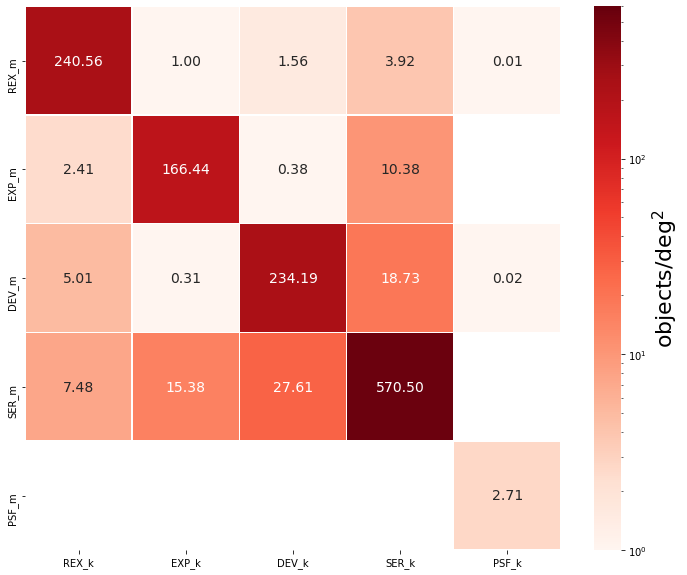

In [171]:
heatmap(morphs_2, morphs_1, vmin=1, vmax=600, file=pathdir+'bgs_morphs_heatmap', ticks=[0.01, 0.1, 1, 10, 100], 
        fmt=".2f", Area=area, log=True, mask = ((bgs2) & (bgs1) & (match)), cat1name=dr1[-1], cat2name=dr2[-1])

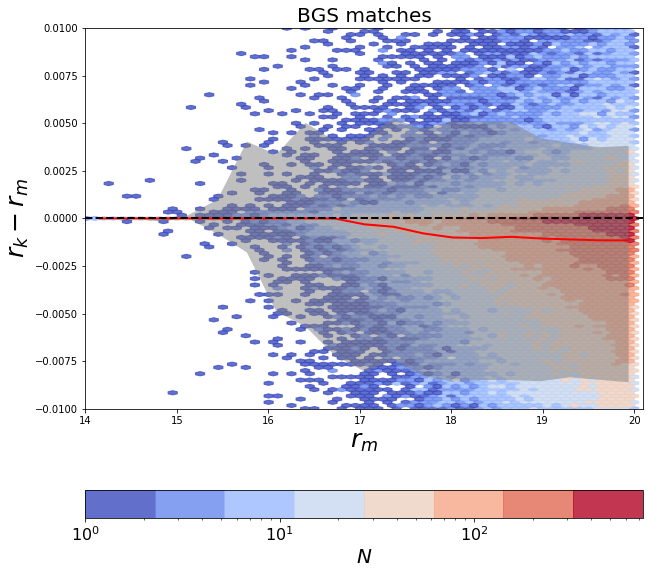

In [172]:
coord = {'$r_{%s}$' %(dr2[-1]):tab['RMAG_%s' %(dr2[-1])], '$r_{%s} - r_{%s}$' %(dr1[-1], dr2[-1]):(tab['RMAG_%s' %(dr1[-1])] - tab['RMAG_%s' %(dr2[-1])])}

fig    = plt.figure(figsize=(10*1.,10*1.))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

ax = hexbin(coord=coord, catmask=((match) & (bgs2) & (bgs1)), n=0, bins='log', title='BGS matches', cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, cbar='horizontal', xlim=[14, 20.1], ylim=[-0.01, 0.01], showmedian=True)
        
plt.axhline(0, lw=2, ls='--', c='k')

# Comparison with GAMA (DECaLS only)

In [10]:
#load GAMA DR4

gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

#get rid of stars in GAMA
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

#
gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA

fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.07 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.93 %


In [11]:
#
def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]

survey = 'south'
cats = {}
for num, dr in enumerate(['dr8', 'dr9k']):
    
    if dr == 'dr9m':
        #load dr9m in G15 from tractors if SWEEPS still not available
        pass
    else:
        #get sweeps for GAMA footprint
        cat =  get_sweep_whole(patch=gama15(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')

    cats[dr] = cat
    

sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr8-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.000370 sec
sweep file already exist at:/global/cscratch1/sd/qmxp55/bgstargets_output/dr9k-south_sweep_211.5_223.5_-2.0_3.0.npy
Total run time: 0.000888 sec


In [12]:
#get rid of objects within BS, LG, NOBS and GC in GAMA

from io_ import match_coord
gamas = {}
for key, cat in zip(cats.keys(), cats.values()):

    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    mask = np.ones_like(cat, dtype=bool)
    for i in ['BS', 'nobs', 'GC']:
        mask &= ((cat['BGSBITS'] & 2**(bgsmask()[i])) != 0)
        mask &= (cat['RMAG'] < 20)
        
    gama_mask = np.ones_like(gama['RA'], dtype='?')
    gama_mask[idx1.tolist()] = mask[idx2]
    
    print('ratio of gama targets after / before these geometrical masks: \t %i / %i' %(np.sum(gama_mask), len(gama)))
    
    gamas[key] = gama[gama_mask]
    
    #print('ratio of total BGS rejected by BS, NOBS, GC / total GAMA matched with these rejected targets: \t %i / %i' %(np.sum(mask), np.sum(gama_mask)))

Doubly matched objects = 0
Final matched objects = 61160
ratio of gama targets after / before these geometrical masks: 	 180869 / 182540
Doubly matched objects = 0
Final matched objects = 61306
ratio of gama targets after / before these geometrical masks: 	 181556 / 182540


In [24]:
#
from io_ import match_gama, gama_assess

def gama_assess_plot(cats=None, gamas=None, savefile=None):
    
    fig = plt.figure(figsize=(20, 6))
    ls = ['-', '--', ':']
    
    for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    
        ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
        gamagal = (ls_z > 0.002)
        val = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['LG'], bgsmask=bgsmask(), rlimit=20)
        
        print('======================= RESULTS %s =======================' %(key))

        print('Total BGS: \t %.3f /deg^2' %(np.sum(val)/60))
        print('GAMA & LS: \t %.2f /deg^2'%(np.sum(ls_gama)/60))
        print('\t GAMA & LS & BGS : \t %.3f /deg^2' % (np.sum(val & ls_gama)/60))
        print('\t GAMA & LS & not in BGS : \t %.3f /deg^2' % (np.sum(~val & ls_gama)/60))
        tot = np.sum(~val & ls_gama)
        print('\t \t & rmag > 20 : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] > 20))/tot))
        print('\t \t & rmag < 20 (rej by a BGS cut) : \t %.3f %%' %(100 * np.sum((~val) & (ls_gama) & (cat['RMAG'] < 20))/tot))

        rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=False)
        rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c = gama_assess(cat=cat, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=True)


        plt.subplot(1, 2, 1)
        plt.plot(rmagl, Ncomp/Ngama_ls, c='k', ls=ls[num], label='bins-%s' %(key))
        plt.plot(rmagl_c, Ncomp_c/Ngama_ls_c, c='r', ls=ls[num], label='cumu-%s' %(key))
        plt.legend()
        
        if num == 0:
            plt.title(r'completeness', size=18)
            plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
            plt.axhline(1, ls='--', c='k')
            plt.axvline(19.2, ls=':', label='19.2', color='k')
            plt.xlabel(r'$r_{mag}$', size=18)
            plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=14)
            plt.ylim(0.95, 1.01)
            plt.grid()


        plt.subplot(1, 2, 2)
        plt.plot(rmagl, Ncont/Ngama_ls, c='k', ls=ls[num], label='bins-%s' %(key))
        plt.plot(rmagl_c, Ncont_c/Ngama_ls_c, c='r', ls=ls[num], label='cumu-%s' %(key))
        plt.legend()
        
        if num == 0:
            plt.title(r'contamination', size=18)
            plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
            plt.axhline(1, ls='--', c='k')
            plt.axvline(19.2, ls=':', label='19.2', color='k')
            plt.xlabel(r'$r_{mag}$', size=18)
            plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=14)
            plt.ylim(0, 1.5)
            plt.grid()

    if savefile is not None:
        fig.savefig(savefile+'.png', bbox_inches = 'tight', pad_inches = 0)


Doubly matched objects = 0
Final matched objects = 59489
======================= RESULTS dr8 =======================
Total BGS: 	 1425.983 /deg^2
GAMA & LS: 	 991.48 /deg^2
	 GAMA & LS & BGS : 	 981.367 /deg^2
	 GAMA & LS & not in BGS : 	 10.117 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %
Doubly matched objects = 0
Final matched objects = 60322
======================= RESULTS dr9k =======================
Total BGS: 	 1481.333 /deg^2
GAMA & LS: 	 1005.37 /deg^2
	 GAMA & LS & BGS : 	 997.200 /deg^2
	 GAMA & LS & not in BGS : 	 8.167 /deg^2
	 	 & rmag > 20 : 	 0.000 %
	 	 & rmag < 20 (rej by a BGS cut) : 	 100.000 %


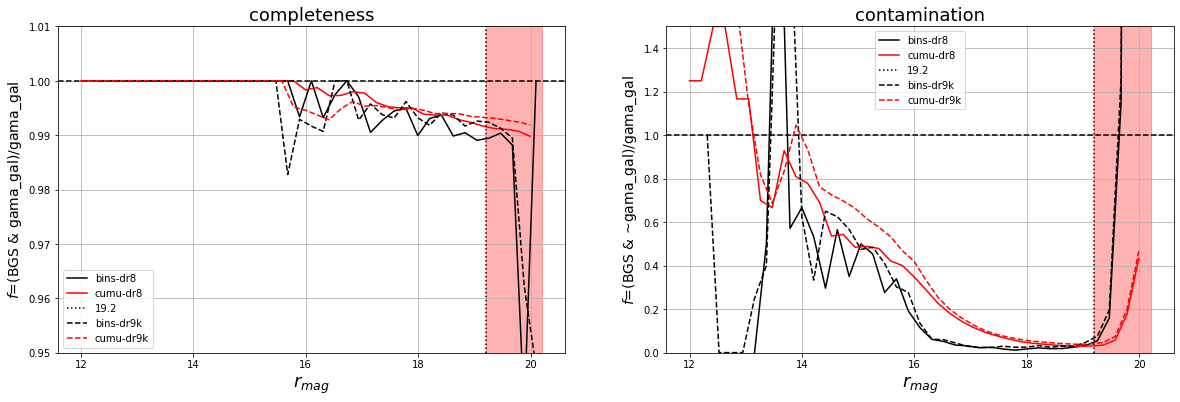

In [25]:
gama_assess_plot(cats=cats, gamas=gamas, savefile='%s/%s'%(pathdir, 'gama_assess_comp_cont'))

In [35]:
def get_bars_gama(labels=None, cats=None, bgsmask=None, log=False, width=None, figsize=(30,10), title=None):
        
    #labels = ['BS', 'MS', 'LG', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    rects = {}

    x = np.arange(len(labels))  # the label locations
    if width is None: width = 0.25  # the width of the bars
    delta = 0

    fig, ax = plt.subplots(figsize=figsize)

    for num, key, cat, gama in zip(range(len(cats.keys())), cats.keys(), cats.values(), gamas.values()):
    
        ls_gama, gama_ls, ls_z = match_gama(cat=cat, gama=gama)
        gamagal = (ls_z > 0.002)
        
        rejs = []
        for i in labels:
            bgsbut_ = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask, rlimit=20)
            rej = ((cat['BGSBITS'] & 2**(bgsmask[i])) != 0)
            pb = (bgsbut_) & (~rej)
            rejs.append(np.sum((ls_gama) & (pb))/np.sum(pb))
            
        #val = [np.sum((bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=[i], bgsmask=bgsmask(), rlimit=20)) & ~((cat['BGSBITS'] & 2**(bgsmask[i])) != 0) & ()) for i in labels]
        
        rects[key] = ax.bar(x - 1*width + delta, rejs, width, label=key)
        delta += width

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('gama & PB / PB', size=30)
    if title is not None: ax.set_title(title, size=30)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=30, rotation=45)
    ax.legend(fontsize=15)
    if log: ax.set_yscale('log')

    for i in rects.keys():
        #autolabel(i)
        #print(i)
        #autolabel(rects[i])
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects[i]:
            height = rect.get_height()
            ax.annotate('{}'.format(np.round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 3, height),
                        xytext=(3, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()

    plt.show()

Doubly matched objects = 0
Final matched objects = 59489
Doubly matched objects = 0
Final matched objects = 60322


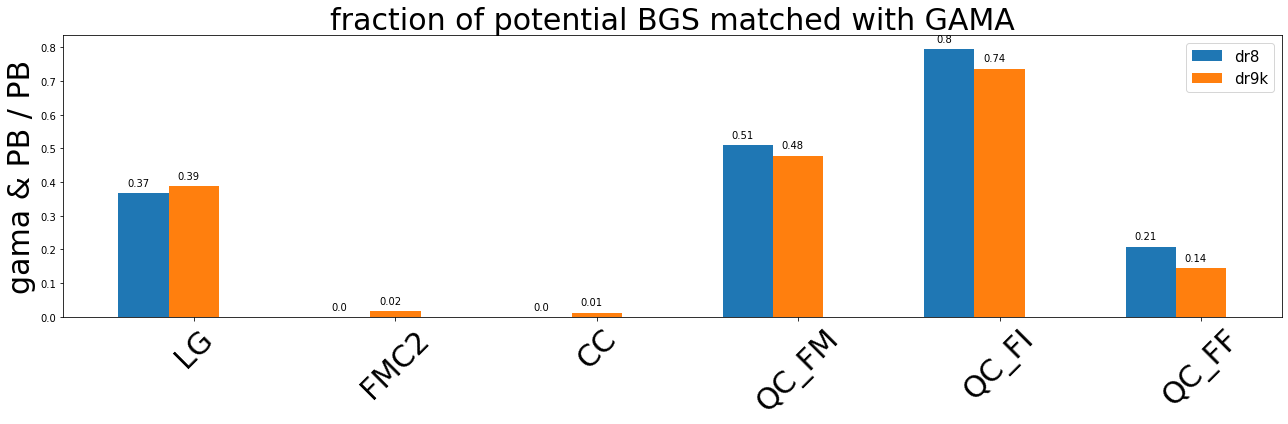

In [36]:
#
labels = ['LG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
get_bars_gama(labels=labels, cats=cats, bgsmask=bgsmask(), title='fraction of potential BGS matched with GAMA', figsize=(18,6))

# Relaxing BGS TS 

## Allmask overlap with FRACS*

`Allmask` has the particularity to be in the RANDOMS while `FRACS*` does not. Look at their agreements and differences with postage images after applying all the other BGS cuts. Do we want to replace `FRACS*` with `Allmask`? 

- Venn diagrams
- postage images of agreements and disagreements

In [11]:
#
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

fracs = np.ones_like(cat, dtype=bool)
bgsbutfracs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
for i in (11,12,13): 
    fracs &= ((cat['BGSBITS'] & 2**(i)) != 0)

#BGS rejected by fracs
bgs_fracs = (bgsbutfracs) & (~fracs)
#BGS rejected by allmask
bgs_allmask = (bgsbutfracs) & (~((cat['BGSBITS'] & 2**(4)) != 0))

print(np.sum(bgs_any), np.sum(bgsbutfracs & fracs))
print(np.sum(bgs_fracs), np.sum(bgs_allmask))


240027 240027
3130 515


Reduced Area within BGS: 	 170.22
Area within BGS: 	 175.72


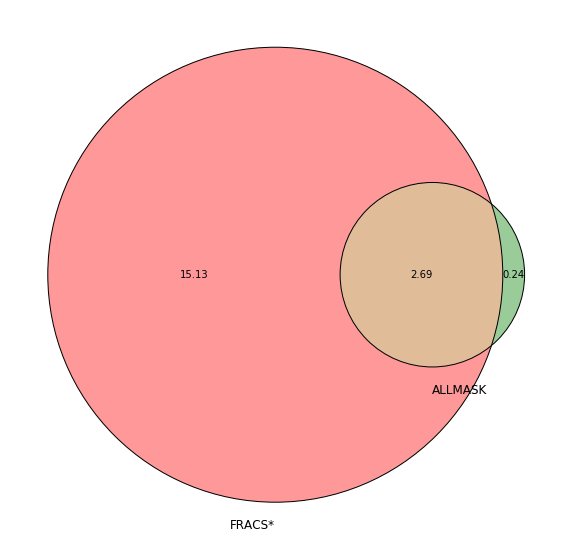

In [12]:
#
print('Reduced Area within BGS: \t %.2f' %(hpdict['bgsarea_'+survey]))
print('Area within BGS: \t %.2f' %(hpdict0['bgsarea_'+survey]))  

area=hpdict0['bgsarea_'+survey]

plot_venn2(A=bgs_fracs, B=bgs_allmask, area=area, title=None, labels=('FRACS*', 'ALLMASK'), savefile='%s/%s' %(pathdir, 'venn2_fracs_vs_allmask'))

## Allmask overlap with relaxed version of FRACS*

This is same test as above but using the relaxed version of `Fracs*` (pass 2 out of 3).

- Venn diagrams
- postage images of agreements and disagreements

In [13]:
#
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

fracs_re = np.ones_like(cat, dtype=bool)
for i in (14,15,16): 
    fracs_re &= ((cat['BGSBITS'] & 2**(i)) != 0)

#BGS rejected by fracs
bgs_fracs_re = (bgsbutfracs) & (~fracs_re)

print('BGS objects rejected by fracs: \t %.3f /sq.deg' %(np.sum(bgs_fracs)/area))
print('BGS objects rejected by fracs relaxed: \t %.3f /sq.deg' %(np.sum(bgs_fracs_re)/area))
print('BGS objects rejected by allmask : \t %.3f /sq.deg' %(np.sum(bgs_allmask)/area))


BGS objects rejected by fracs: 	 17.812 /sq.deg
BGS objects rejected by fracs relaxed: 	 7.700 /sq.deg
BGS objects rejected by allmask : 	 2.931 /sq.deg


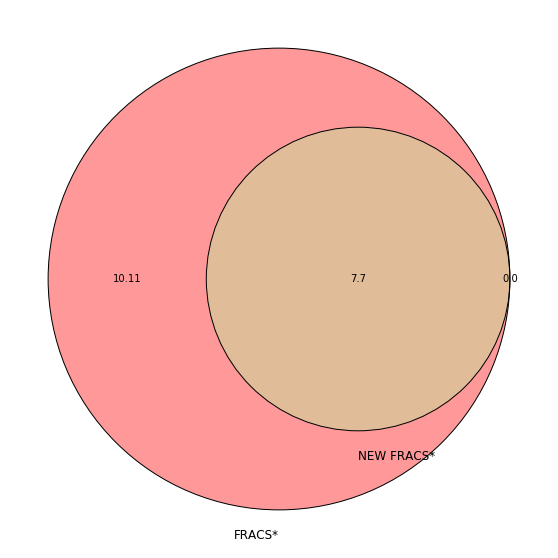

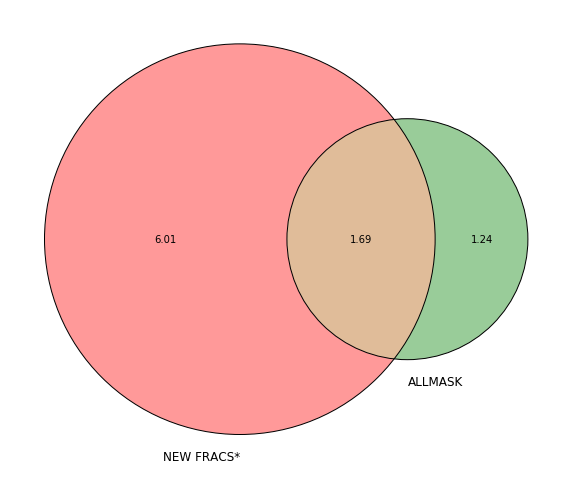

In [14]:
#

plot_venn2(A=bgs_fracs, B=bgs_fracs_re, area=area, title=None, labels=('FRACS*', 'NEW FRACS*'), savefile='%s/%s' %(pathdir, 'venn2_comparison_fracs'))

plot_venn2(A=bgs_fracs_re, B=bgs_allmask, area=area, title=None, labels=('NEW FRACS*', 'ALLMASK'), savefile='%s/%s' %(pathdir, 'venn2_fracs_re_vs_allmask'))


## Gallery: FRACS* & NEW FRACS

    1) NEW FRACS*
    2) FRACS* not in NEW FRACS*
    3) ALLMASK not in NEW FRACS*


In [15]:
rmaglim = (cat['RMAG'] < 19) & (cat['RMAG'] > 18)
galls = {'NEW FRACS*':(bgs_fracs_re) & (rmaglim), 'FRACS* not in NEW FRACS*':(bgs_fracs) & (~bgs_fracs_re) & (rmaglim), 'ALLMASK not in NEW FRACS*':(bgs_allmask) & (~bgs_fracs_re) & (rmaglim)}

for key, val in zip(galls.keys(), galls.values()):
    print(np.sum(val))

323
363
41


In [16]:
#
veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
info_list = ['RA', 'DEC', 'RMAG', 'GMAG', 'ZMAG', 'TYPE', 'REF_CAT']
info = {key:cat[key] for key in info_list}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]
coord = [cat['RA'], cat['DEC']]
grid = [8,5]

tabs = []
galls = {'NEW FRACS*':(bgs_fracs_re), 'FRACS* not in NEW FRACS*':(bgs_fracs) & (~bgs_fracs_re), 'ALLMASK not in NEW FRACS*':(bgs_allmask) & (~bgs_fracs_re)}
rmaglims = {'r < 18':(cat['RMAG'] < 18), '18 < r < 19':(cat['RMAG'] < 19) & (cat['RMAG'] > 18), '19 < r < 20':(cat['RMAG'] < 20) & (cat['RMAG'] > 19)}

for key, val in zip(galls.keys(), galls.values()):
    
    for key2, val2 in zip(rmaglims.keys(), rmaglims.values()):
    
        print('%s (%s): \t %.3f, \t %.3f' %(key, key2, np.sum((val) & (val2))/area, np.sum((val) & (val2))))

        idx = list(np.where((val) & (val2)))[0]
        title = 'BGS rejected by %s at %s' %(key, key2)
        buttons_text = 'select which images and object \n markers you want to display'
        tab_title = '%s (%s)' %(key, key2)

    #
        tab = html_postages(coord=coord, idx=idx, veto=veto, info=info, grid=grid, layer_list=layer_list, title=title, 
                  buttons_text=buttons_text, tab=True, tab_title=tab_title)


        tabs.append(tab)


NEW FRACS* (r < 18): 	 1.747, 	 307.000


Loading BokehJS ...

32.0 122
NEW FRACS* (18 < r < 19): 	 1.838, 	 323.000


Loading BokehJS ...

32.0 122
NEW FRACS* (19 < r < 20): 	 4.114, 	 723.000


Loading BokehJS ...

32.0 122
FRACS* not in NEW FRACS* (r < 18): 	 1.184, 	 208.000


Loading BokehJS ...

32.0 122
FRACS* not in NEW FRACS* (18 < r < 19): 	 2.066, 	 363.000


Loading BokehJS ...

32.0 122
FRACS* not in NEW FRACS* (19 < r < 20): 	 6.863, 	 1206.000


Loading BokehJS ...

32.0 122
ALLMASK not in NEW FRACS* (r < 18): 	 0.256, 	 45.000


Loading BokehJS ...

32.0 122
ALLMASK not in NEW FRACS* (18 < r < 19): 	 0.233, 	 41.000


Loading BokehJS ...

32.0 122
ALLMASK not in NEW FRACS* (19 < r < 20): 	 0.751, 	 132.000


Loading BokehJS ...

32.0 122


In [17]:
#
savefile = '%s/%s' %(pathdir, 'NEW_FRACS_FRACS_and_ALLMASK_differences')

bk.output_notebook()
if savefile is not None:
    html_page = savefile + '.html'
    bk.output_file(html_page, title=savefile)
    print(html_page)

# Put all the tabs into one application
page = Tabs(tabs=tabs)

# Put the tabs in the current document for display
show(page)

Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_svfields_k_0.1.0_draft_plots/NEW_FRACS_FRACS_and_ALLMASK_differences.html


## GAMA completeness

To assess above test, run GAMA completeness for:

1) Nominal BGS

2) Using `allmask` instead of `fracs*`

3) Using relaxed version of `fracs*`

Which one has the better completeness?

In [18]:
#load GAMA DR4

gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

#get rid of stars in GAMA
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

#
gama0 = gama #Include stars and galaxies in GAMA
gama = gama0[gama0['Z'] > 0.002] #Include only galaxies in GAMA

fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.07 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.93 %


In [28]:
#
def gama12():
    
    return [174., 186., -3., 2.]

def gama15():
    
    return [211.5, 223.5, -2., 3.]

def gama09():
    
    return [129., 141., -2., 3.]

    
#get sweeps for GAMA footprint
lsing15 =  get_sweep_whole(patch=gama15(), dr=dr+'-'+survey, rlimit=None, maskbitsource=False, bgsbits=True, opt='1')


	 fraction: 1421419/1421419 objects
	 fraction: 2070945/2070945 objects
	 fraction: 620560/620560 objects
	 fraction: 831413/831413 objects
	 Sample # objects: 4944337
---- BGSMASK key: ---- 
	 BS, 0, 1
	 MS, 1, 2
	 GC, 2, 4
	 LG, 3, 8
	 allmask, 4, 16
	 nobs, 5, 32
	 SG, 6, 64
	 SGSV, 7, 128
	 FMC, 8, 256
	 FMC2, 9, 512
	 CC, 10, 1024
	 QC_FM, 11, 2048
	 QC_FI, 12, 4096
	 QC_FF, 13, 8192
	 QC_FM2, 14, 16384
	 QC_FI2, 15, 32768
	 QC_FF2, 16, 65536
	 QC_IVAR, 17, 131072
	 bgs_any, 20, 1048576
	 bgs_bright, 21, 2097152
	 bgs_faint, 22, 4194304
	 bgs_sv_any, 30, 1073741824
	 bgs_sv_bright, 31, 2147483648
	 bgs_sv_faint, 32, 4294967296
	 bgs_sv_faint_ext, 33, 8589934592
	 bgs_sv_fibmag, 34, 17179869184
	 bgs_sv_lowq, 35, 34359738368
---- Sanity Check ---- 
	 BS, 4840705, 4840705
	 MS, 4767024, 4767024
	 GC, 4944337, 4944337
	 LG, 4941178, 4941178
	 allmask, 4921628, 4921628
	 nobs, 4940768, 4940768
	 SG, 4651266, 4651266
	 SGSV, 4651921, 4651921
	 FMC, 4921643, 4921643
	 FMC2, 4922412, 492

In [29]:
from io_ import match_gama, gama_assess
ls_gama, gama_ls, ls_z = match_gama(cat=lsing15, gama=gama)


Doubly matched objects = 0
Final matched objects = 61160


In [30]:
#

def gama_assess_plot(pop=['QC_FM', 'QC_FI', 'QC_FF'], savefile=None):
    
    gamagal = (ls_z > 0.002)


    bgsbutfracs = bgsbut(bgsbits=lsing15['BGSBITS'], rmag=lsing15['RMAG'], pop=pop, bgsmask=bgsmask(), rlimit=20)
    fracs_re = np.ones_like(lsing15, dtype=bool)
    for i in (14,15,16): 
        fracs_re &= ((lsing15['BGSBITS'] & 2**(i)) != 0)

    #BGS with fracs relaxed
    bgs_re = (bgsbutfracs) & (fracs_re)

    #BGS with allmask
    bgs_allmask = (bgsbutfracs) & (((lsing15['BGSBITS'] & 2**(4)) != 0))

    #nominal BGS
    bgs = ((lsing15['BGSBITS'] & 2**(20)) != 0)

    dictBGS = {'BGS nominal':bgs, 'BGS FRACS* relaxed':bgs_re, 'BGS with allmask':bgs_allmask}

    #
    fig = plt.figure(figsize=(30, 12))

    print('GAMA & LS %s: %.2f /deg^2'%(dr, np.sum(ls_gama)/60))

    for num, key, val in zip([1,2,3], dictBGS.keys(), dictBGS.values()):

        print('\t %s: \t %.3f /deg^2, \& in GAMA: \t %.3f /deg^2' % (key, np.sum(val)/60, np.sum(val & ls_gama)/60))

        rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=lsing15, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=False)
        rmagl_c, Ncomp_c, Ncont_c, Nincomp_c, Ngama_ls_c, Ntot_c = gama_assess(cat=lsing15, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val, cumu=True)



        plt.subplot(2, 3, num)
        plt.title(r' %s completeness' %(key), size=18)
        plt.plot(rmagl, Ncomp/Ngama_ls, c='k', ls='-', label='bins')
        plt.plot(rmagl_c, Ncomp_c/Ngama_ls_c, c='r', ls='-', label='cumu')
        plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
        plt.axhline(1, ls='--', c='k')
        plt.axvline(19.2, ls=':', label='19.2', color='k')
        plt.xlabel(r'$r_{mag}$', size=18)
        plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=14)
        plt.ylim(0.8, 1.05)
        plt.legend()
        plt.grid()


        plt.subplot(2, 3, num+3)
        plt.title(r'%s contamination' %(key), size=18)
        plt.plot(rmagl, Ncont/Ngama_ls, c='k', ls='-', label='bins')
        plt.plot(rmagl_c, Ncont_c/Ngama_ls_c, c='r', ls='-', label='cumu')
        plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
        plt.axhline(1, ls='--', c='k')
        plt.axvline(19.2, ls=':', label='19.2', color='k')
        plt.xlabel(r'$r_{mag}$', size=18)
        plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=14)
        plt.ylim(0, 2)
        plt.legend()
        plt.grid()

    if savefile is not None:
        fig.savefig(savefile+'.png', bbox_inches = 'tight', pad_inches = 0)


GAMA & LS dr8: 1019.33 /deg^2
	 BGS nominal: 	 1422.400 /deg^2, \& in GAMA: 	 980.050 /deg^2
	 BGS FRACS* relaxed: 	 1429.550 /deg^2, \& in GAMA: 	 983.633 /deg^2
	 BGS with allmask: 	 1432.283 /deg^2, \& in GAMA: 	 983.617 /deg^2


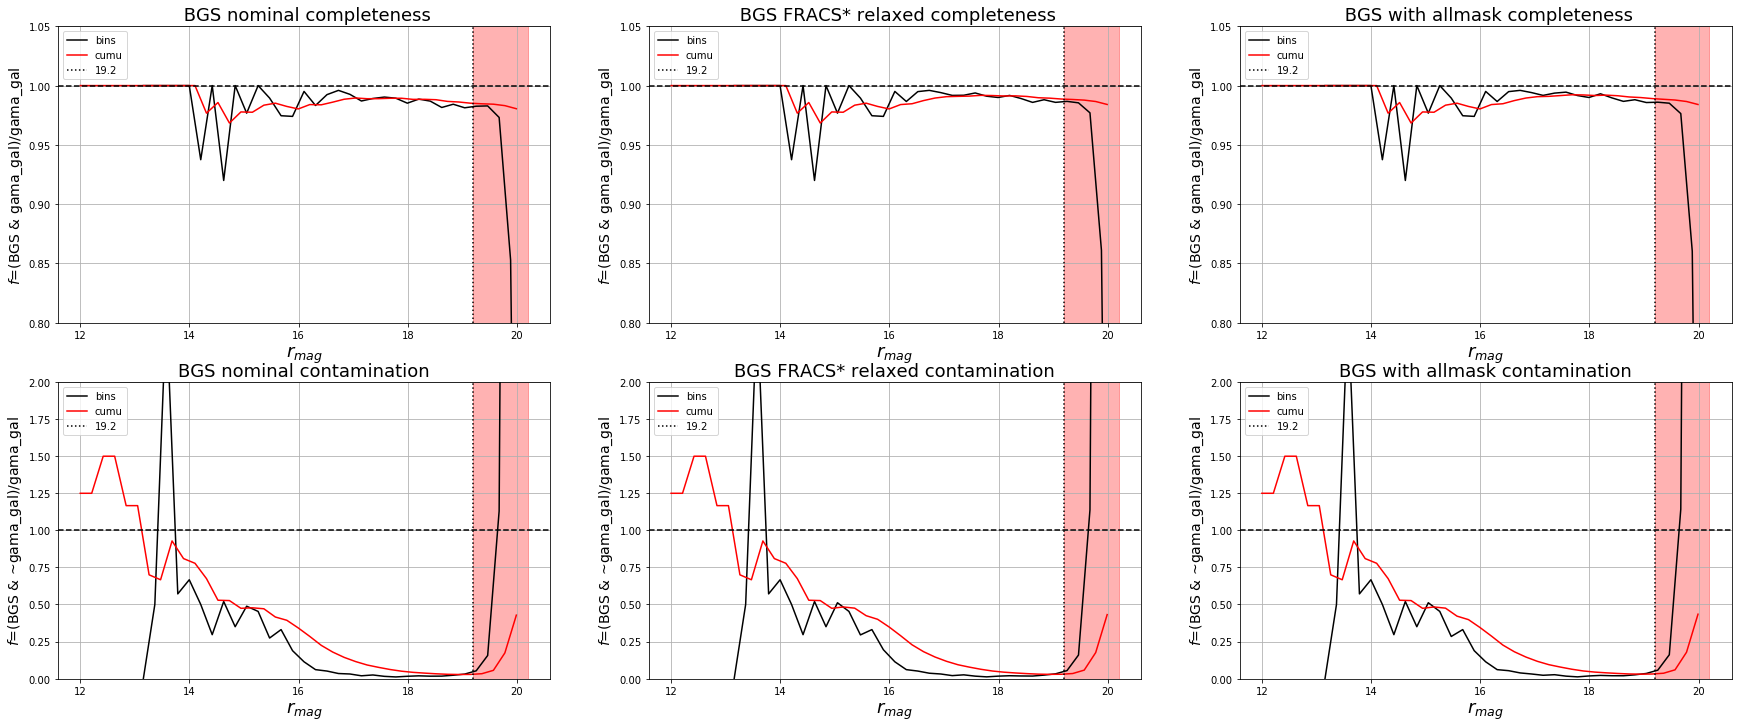

In [31]:
gama_assess_plot(pop=['QC_FM', 'QC_FI', 'QC_FF'], savefile='%s/%s'%(pathdir, 'gama_assess_comp_cont'))

GAMA & LS dr8: 1019.33 /deg^2
	 BGS nominal: 	 1422.400 /deg^2, \& in GAMA: 	 980.050 /deg^2
	 BGS FRACS* relaxed: 	 1433.317 /deg^2, \& in GAMA: 	 985.000 /deg^2
	 BGS with allmask: 	 1436.150 /deg^2, \& in GAMA: 	 985.000 /deg^2


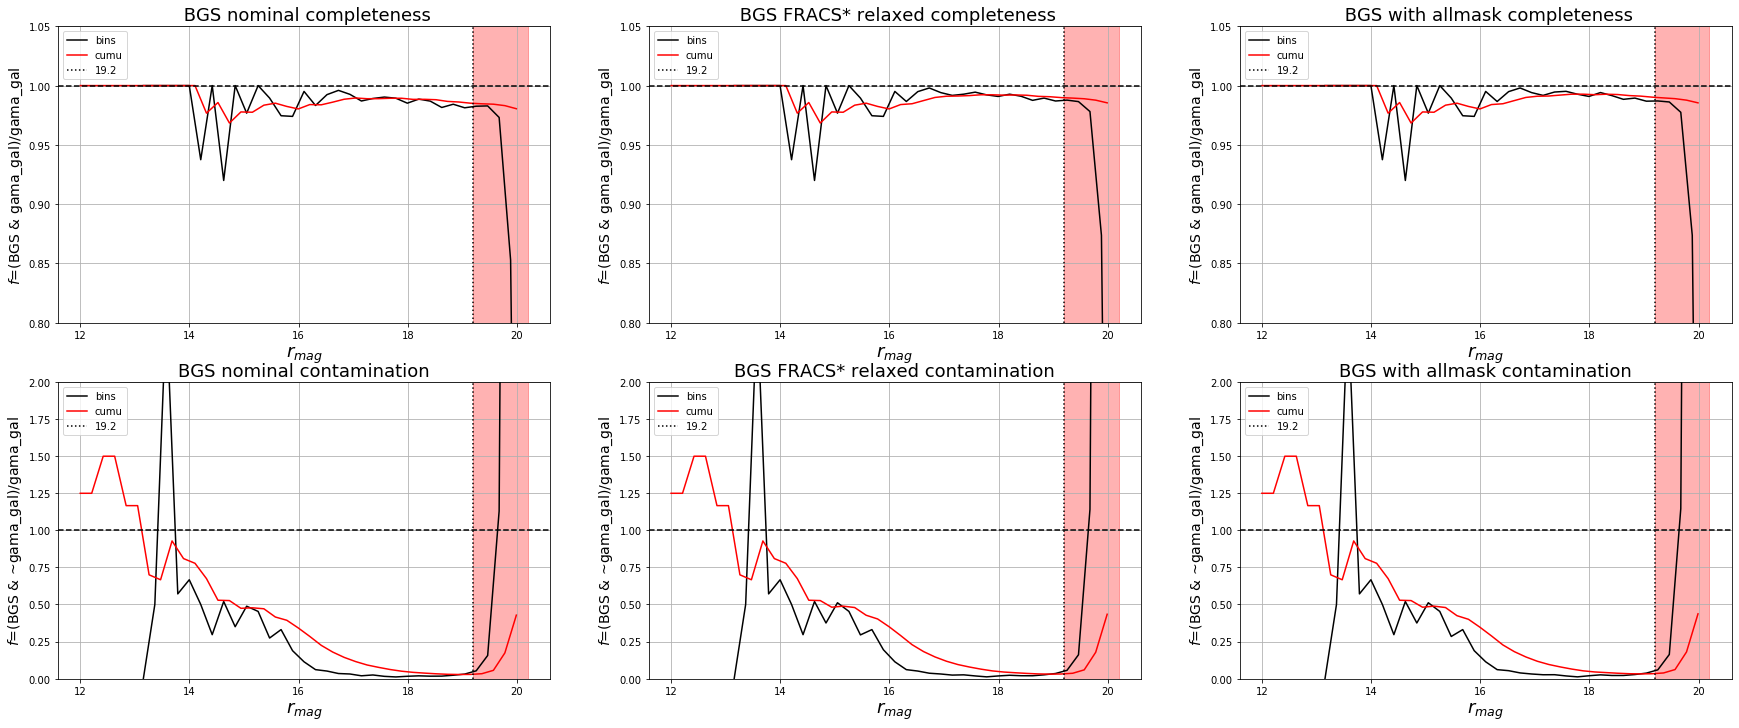

In [32]:
gama_assess_plot(pop=['LG', 'QC_FM', 'QC_FI', 'QC_FF'], savefile='%s/%s'%(pathdir, 'gama_assess_LG_comp_cont'))

In [33]:
def gama_assess_plot_2(pop=None, savefile=None, FracsReAllmask=True, FracsReAllmask_LG=True, comp=True):
    
    #pop = {'nominal':None, }
    
    gamagal = (ls_z > 0.002)
    #
    fig = plt.figure(figsize=(27, 8))
    
    print('GAMA & LS %s: %.2f /deg^2'%(dr, np.sum(ls_gama)/60))
    
    if FracsReAllmask:
        bgsbutfracs = bgsbut(bgsbits=lsing15['BGSBITS'], rmag=lsing15['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
        fracs_re = np.ones_like(lsing15, dtype=bool)
        for i in (14,15,16): 
            fracs_re &= ((lsing15['BGSBITS'] & 2**(i)) != 0)
        #BGS with fracs relaxed
        bgs_re = (bgsbutfracs) & (fracs_re)
        #BGS with allmask
        bgs_allmask = (bgsbutfracs) & (((lsing15['BGSBITS'] & 2**(4)) != 0))
        
        dictBGS = {'NEW FRACS*':bgs_re, 'ALLMASK & no FRACS':bgs_allmask}
        
    if FracsReAllmask_LG:
        bgsbutfracs = bgsbut(bgsbits=lsing15['BGSBITS'], rmag=lsing15['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=20)
        fracs_re = np.ones_like(lsing15, dtype=bool)
        for i in (14,15,16): 
            fracs_re &= ((lsing15['BGSBITS'] & 2**(i)) != 0)
        #BGS with fracs relaxed
        bgs_re_LG = (bgsbutfracs) & (fracs_re)
        #BGS with allmask
        bgs_allmask_LG = (bgsbutfracs) & (((lsing15['BGSBITS'] & 2**(4)) != 0))
        
        dictBGS_LG = {'NEW FRACS no LG*':bgs_re_LG, 'ALLMASK & no FRACS & no LG':bgs_allmask_LG}
        
    
    for num, cumu in enumerate([False, True]):
        
        if cumu: label = 'Cumulative'
        else: label = 'bins'
                
        plt.subplot(1, 2, num+1)
        if comp: plt.title(r' BGS completeness with GAMA (%s)' %(label), size=18)
        else: plt.title(r' BGS contamination with GAMA (%s)' %(label), size=18)
        plt.axvspan(19.2, 20.2, alpha=0.3, color='red')
        plt.axhline(1, ls='--', c='k')
        plt.axvline(19.2, ls=':', label='19.2', color='k')
        plt.xlabel(r'$r_{mag}$', size=25)
        if comp: plt.ylabel(r'$f$=(BGS & gama_gal)/gama_gal', size=20)
        else: plt.ylabel(r'$f$=(BGS & ~gama_gal)/gama_gal', size=20)
        
        for key, val in zip(pop.keys(), pop.values()):
            
            bgsbutx = bgsbut(bgsbits=lsing15['BGSBITS'], rmag=lsing15['RMAG'], pop=val, bgsmask=bgsmask(), rlimit=20)
            if not cumu: print('\t %s: \t %.3f /deg^2, \t in GAMA: \t %.3f /deg^2' % (key, np.sum(bgsbutx)/60, np.sum(bgsbutx & ls_gama)/60))
            rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=lsing15, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=bgsbutx, cumu=cumu)
            
            if comp: plt.plot(rmagl, Ncomp/Ngama_ls, ls='-', label='%s' %(key))
            else: plt.plot(rmagl, Ncont/Ngama_ls, ls='-', label='%s' %(key))
            if not cumu: plt.legend()
            
        if FracsReAllmask:
            
            for key_ex, val_ex in zip(dictBGS.keys(), dictBGS.values()):
                
                if not cumu: print('\t %s: \t %.3f /deg^2, \t in GAMA: \t %.3f /deg^2' % (key_ex, np.sum(val_ex)/60, np.sum(val_ex & ls_gama)/60))
                
                rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=lsing15, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val_ex, cumu=cumu)
                if comp: plt.plot(rmagl, Ncomp/Ngama_ls, ls='-', label='%s' %(key_ex))
                else: plt.plot(rmagl, Ncont/Ngama_ls, ls='-', label='%s' %(key_ex))
                if not cumu: plt.legend()
                
        if FracsReAllmask_LG:
            
            for key_ex, val_ex in zip(dictBGS_LG.keys(), dictBGS_LG.values()):
                
                if not cumu: print('\t %s: \t %.3f /deg^2, \t in GAMA: \t %.3f /deg^2' % (key_ex, np.sum(val_ex)/60, np.sum(val_ex & ls_gama)/60))
                
                rmagl, Ncomp, Ncont, Nincomp, Ngama_ls, Ntot = gama_assess(cat=lsing15, rmaglab='RMAG', match=ls_gama, gamagal=gamagal, mask=val_ex, cumu=cumu)
                if comp: plt.plot(rmagl, Ncomp/Ngama_ls, ls='-', label='%s' %(key_ex))
                else: plt.plot(rmagl, Ncont/Ngama_ls, ls='-', label='%s' %(key_ex))
                if not cumu: plt.legend()
                

        if comp: plt.ylim(0.94, 1.02)
        else: plt.ylim(0, 1.25)
        plt.grid()
            
        if savefile is not None:
            fig.savefig(savefile+'.png', bbox_inches = 'tight', pad_inches = 0)


GAMA & LS dr8: 1019.33 /deg^2
	 Nominal: 	 1422.400 /deg^2, 	 in GAMA: 	 980.050 /deg^2
	 no LG: 	 1425.983 /deg^2, 	 in GAMA: 	 981.367 /deg^2
	 no FRACS*: 	 1434.300 /deg^2, 	 in GAMA: 	 984.167 /deg^2
	 no FRACS* & no LG: 	 1438.167 /deg^2, 	 in GAMA: 	 985.550 /deg^2
	 NEW FRACS*: 	 1429.550 /deg^2, 	 in GAMA: 	 983.633 /deg^2
	 ALLMASK & no FRACS: 	 1432.283 /deg^2, 	 in GAMA: 	 983.617 /deg^2
	 NEW FRACS no LG*: 	 1433.317 /deg^2, 	 in GAMA: 	 985.000 /deg^2
	 ALLMASK & no FRACS & no LG: 	 1436.150 /deg^2, 	 in GAMA: 	 985.000 /deg^2


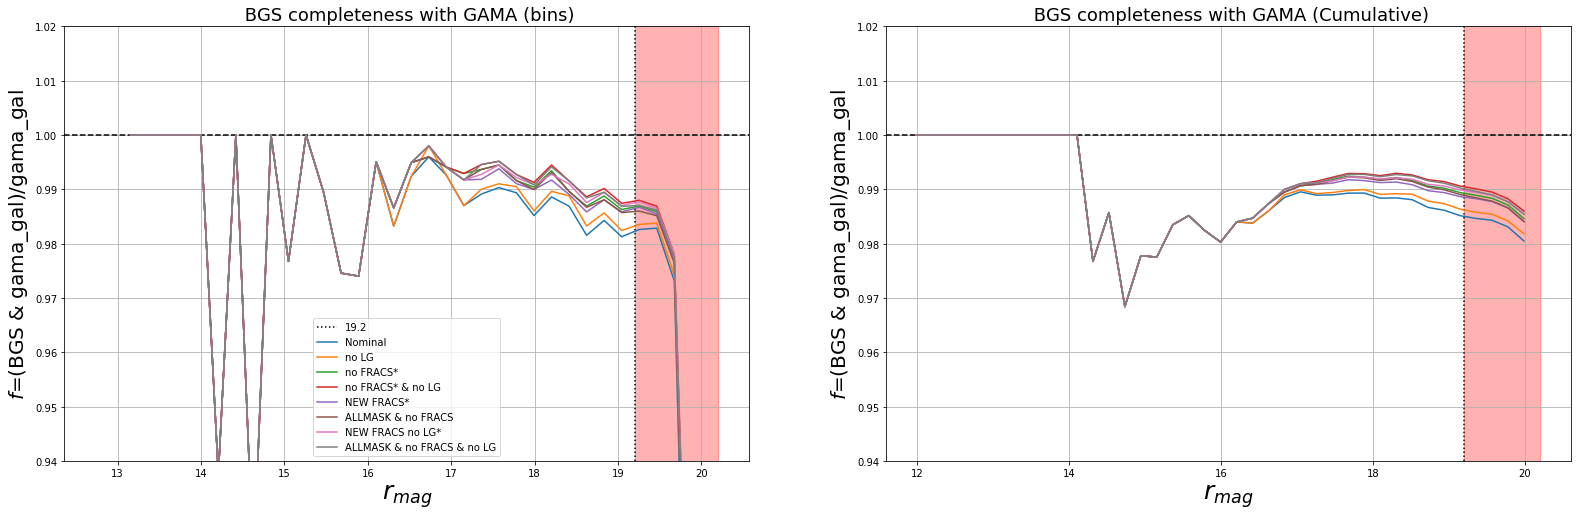

In [34]:
gama_assess_plot_2(pop={'Nominal':None, 'no LG':['LG'], 'no FRACS*':['QC_FM', 'QC_FI', 'QC_FF'], 'no FRACS* & no LG':['QC_FM', 'QC_FI', 'QC_FF', 'LG']}, savefile='%s/%s'%(pathdir, 'gama_assess_LG_comp_alltogether'))

GAMA & LS dr8: 1019.33 /deg^2
	 Nominal: 	 1422.400 /deg^2, 	 in GAMA: 	 980.050 /deg^2
	 no LG: 	 1425.983 /deg^2, 	 in GAMA: 	 981.367 /deg^2
	 no FRACS*: 	 1434.300 /deg^2, 	 in GAMA: 	 984.167 /deg^2
	 no FRACS* & no LG: 	 1438.167 /deg^2, 	 in GAMA: 	 985.550 /deg^2
	 NEW FRACS*: 	 1429.550 /deg^2, 	 in GAMA: 	 983.633 /deg^2
	 ALLMASK & no FRACS: 	 1432.283 /deg^2, 	 in GAMA: 	 983.617 /deg^2
	 NEW FRACS no LG*: 	 1433.317 /deg^2, 	 in GAMA: 	 985.000 /deg^2
	 ALLMASK & no FRACS & no LG: 	 1436.150 /deg^2, 	 in GAMA: 	 985.000 /deg^2


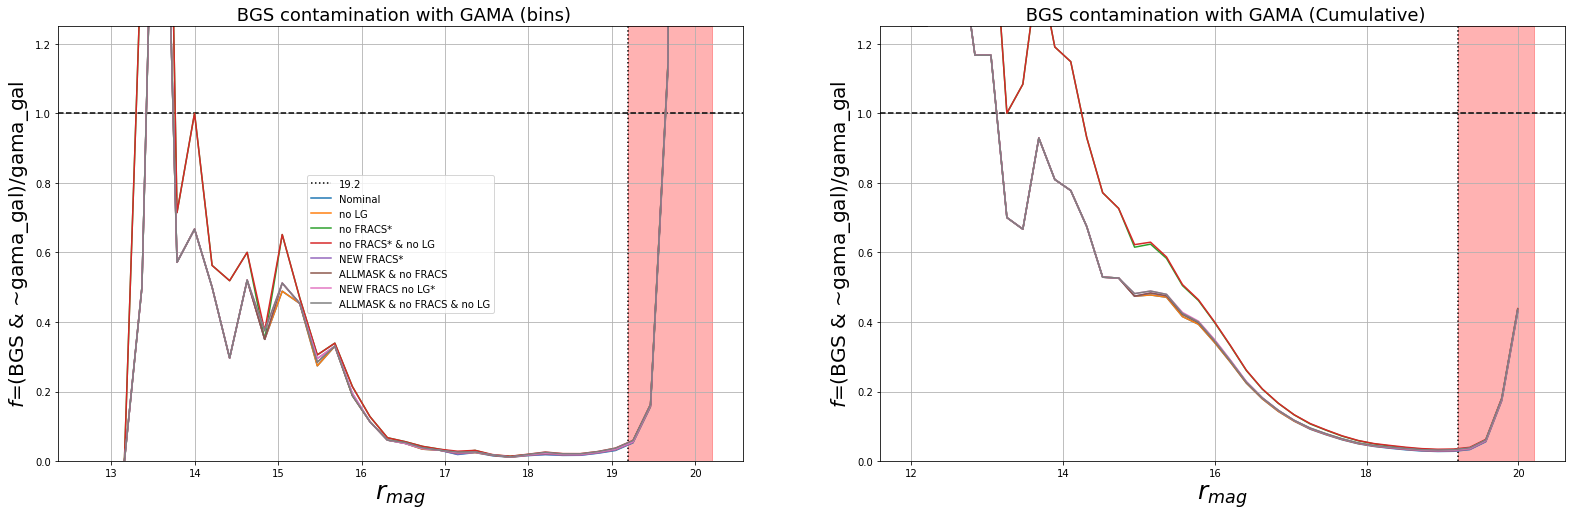

In [35]:
gama_assess_plot_2(pop={'Nominal':None, 'no LG':['LG'], 'no FRACS*':['QC_FM', 'QC_FI', 'QC_FF'], 'no FRACS* & no LG':['QC_FM', 'QC_FI', 'QC_FF', 'LG']}, savefile='%s/%s'%(pathdir, 'gama_assess_LG_comp_alltogether'), comp=False)

### What if we don't apply the LG mask? Do the completeness increases?

# DEV ZONE...

## Grr vs g-z: bgsbutSG

In [18]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutSG = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutSG &= keep
#bgsbutSG &= cat['RMAG'] < 20

bgsbutSG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)

finite = np.ones_like(cat['RMAG'], dtype='?')
for i in ['RMAG', 'GMAG', 'ZMAG','FLUX_R', 'RFIBERMAG']:
    finite &= np.isfinite(cat[i])
    

In [ ]:
Ared = hpdict['bgsarea_'+reg]

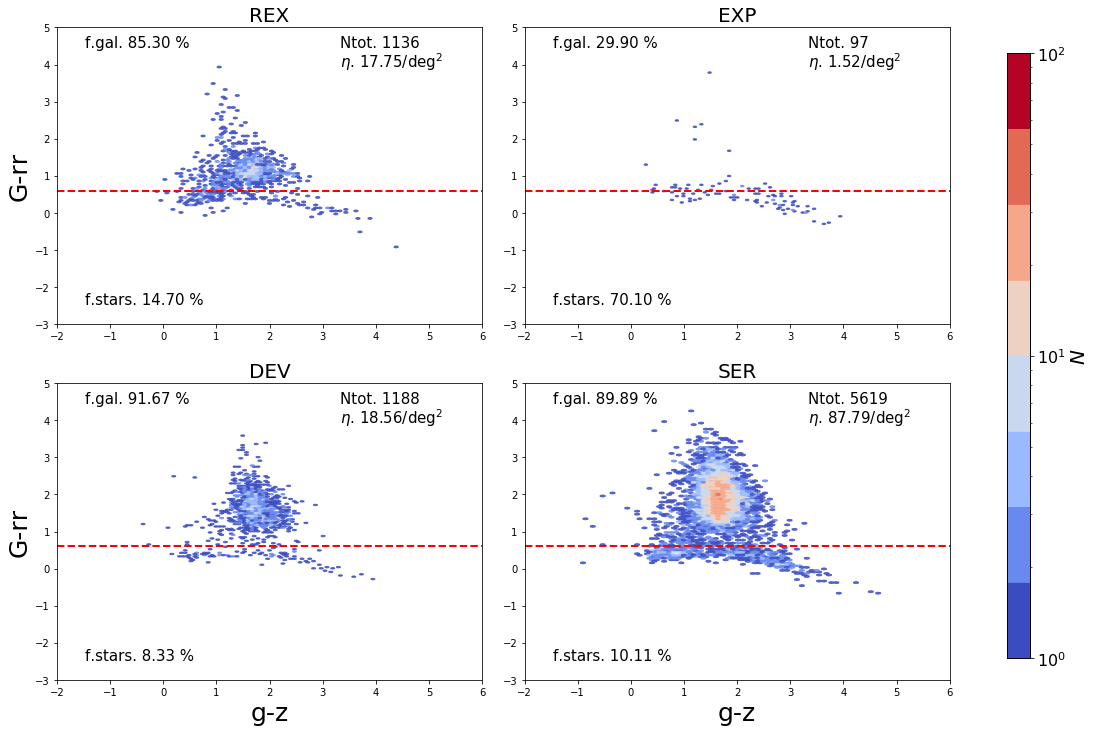

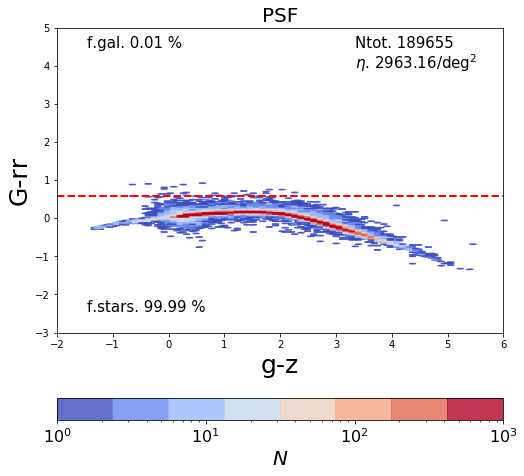

In [ ]:
#
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])
coord = {'g-z':cat['GMAG'] - cat['ZMAG'], 'G-rr':Grr}
PSF = (cat['TYPE'] == 'PSF ') | (cat['TYPE'] == 'PSF') 
#if dr[:3] == 'dr9': morphos = ['REX', 'EXP', 'DEV', 'SER']
#else: morphos = ['REX ', 'EXP ', 'DEV ', 'COMP']
rows, cols = 2, 2
#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutSG) & (finite) #& (debug)
hline, vline = 0.6, None
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.2, wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if (morpho == PSF): 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 100, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap=cmap, 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_extended_%s' %(pathdir, survey), fracs=True, area=Ared, cbar=cbar)

fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (PSF)), n=0, bins='log', title='PSF', cmap=cmap, 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000, mincnt=1, 
                   file='%s/gz_Grr_bgsbutSG_hexbin_psf_%s' %(pathdir, survey), fracs=True, area=Ared, cbar='horizontal')
        

## rmag vs rfibmag: bgsbutFMC

In [ ]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
    
## get BGS objects without BS bit set on
#bgsbutFMC2 = np.ones_like(cat['RA'], dtype=bool)

#for key in bgslist:
#    keep = ((cat['BGSBITS'] & 2**(bgsmask()[key])) != 0)
#    bgsbutFMC2 &= keep
#bgsbutFMC2 &= cat['RMAG'] < 20

bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask(), rlimit=20)


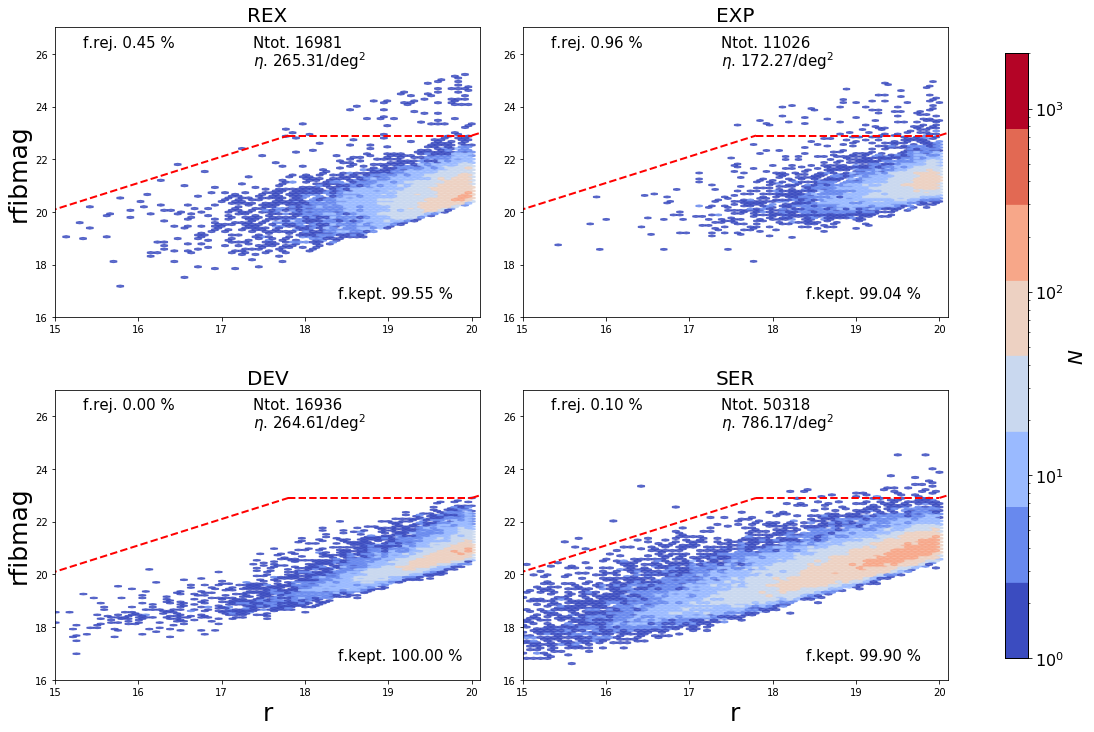

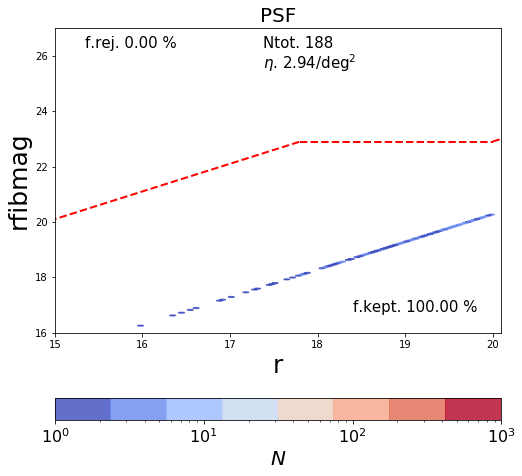

In [ ]:
#
rows, cols = 2, 2
coord = {'r':cat['RMAG'], 'rfibmag':cat['RFIBERMAG']}

#debug = cat['RMAG'] < 16
mask = (catinreg) & (bgsbutFMC2) & (finite) #& (debug)
hline, vline = None, None
vmin, vmax = 1, 200
    
fig    = plt.figure(figsize=(8*cols,6*rows))
gs     = gridspec.GridSpec(rows, cols, hspace=0.25, wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
    
for i, morpho in enumerate(morphos):
        
    if (i%cols==0): ylab=True
    else: ylab = False
    if morpho == PSF: 
        vmax, cbar = None, 'vertical'
    else:
        vmax, cbar = 2000, 'panel'
        
    if i < 2: xlab = False
    else: xlab = True
        
    morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=((mask) & (morphomask)), n=i, bins='log', title=morpho, cmap=cmap, 
               ylab=ylab, xlab=xlab, vline=vline, hline=hline, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=True, 
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_extended_%s' %(pathdir, survey), fracs=False, area=Ared, cbar=cbar)
    
    
fig    = plt.figure(figsize=(8*1,8*1))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)

hexbin(coord=coord, catmask=((mask) & (PSF)), n=0, bins='log', title='PSF', cmap=cmap, 
               ylab=True, vline=vline, hline=hline, fig=fig, gs=gs, vmin=None, vmax=1000, mincnt=1, fmcline=True,
                   file='%s/r_rfibmag_bgsbutFMC2_hexbin_psf_%s' %(pathdir, survey), fracs=False, area=Ared, cbar='horizontal')
        

## g-r vs r-z: bgsbutCC

In [ ]:

bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask(), rlimit=20)


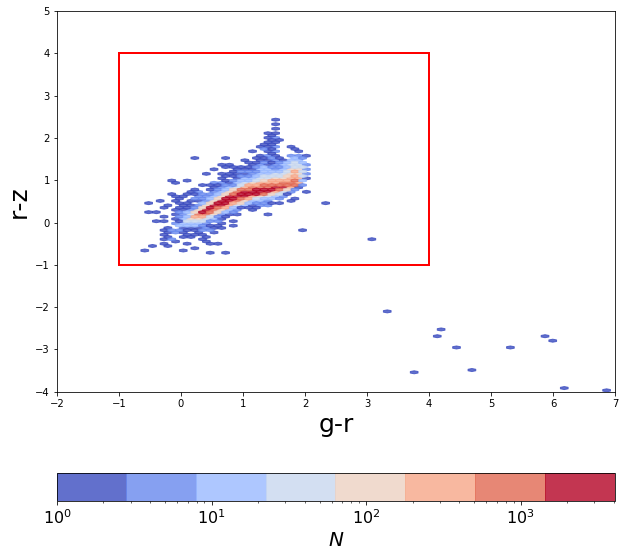

In [ ]:
#
import matplotlib.patches as patches

coord = {'g-r':cat['GMAG'] - cat['RMAG'], 'r-z':cat['RMAG'] - cat['ZMAG']}
mask = (catinreg) & (bgsbutCC) & (finite) # & (cat['RMAG'] < 14)

fig   = plt.figure(figsize=(10,10))
gs     = gridspec.GridSpec(1, 1, hspace=0.15, wspace=0.10)


hexbin(coord=coord, catmask=mask, n=0, bins='log', title=None, cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, xlim=(-2, 7), ylim=(-4, 5), 
                   vmin=None, vmax=None, mincnt=1, fmcline=False,
                       file=None, fracs=False, area=Ared, cbar='horizontal')

plt.plot(np.linspace(-1, 4, 3), np.full(3, -1), lw=2, c='r')
plt.plot(np.linspace(-1, 4, 3), np.full(3, 4), lw=2, c='r')

plt.plot(np.full(3, -1), np.linspace(-1, 4, 3), lw=2, c='r')
plt.plot(np.full(3, 4), np.linspace(-1, 4, 3), lw=2, c='r')

file='%s/gr_rz_bgsbutCC_hexbin_%s' %(pathdir, survey)
fig.savefig(file, bbox_inches = 'tight', pad_inches = 0)



## Venn diagrams: QCs

In [ ]:
from QA import plot_venn3

In [ ]:
# get BGS but QCs
bgsbutQCs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF'], bgsmask=bgsmask(), rlimit=20)
FM = ((cat['BGSBITS'] & 2**(11)) == 0) #rejects by FM
FI = ((cat['BGSBITS'] & 2**(12)) == 0) #rejects by FI
FF = ((cat['BGSBITS'] & 2**(13)) == 0) #rejects by FF
area = hpdict0['bgsarea_'+survey]

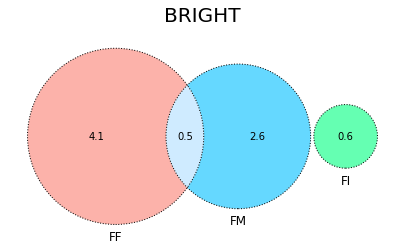

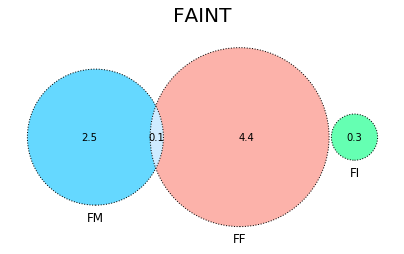

In [ ]:
#
keepB = (bgsbutQCs) & (cat['RMAG'] < 19.5)
keepF = (bgsbutQCs) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20)
plot_venn3(A=(keepB & FM), B=(keepB & FI), C=(keepB & FF), norm=area, 
           labels=['FM', 'FI', 'FF'], file=pathdir+'/venn_QCs_bright_%s' %(survey), title='BRIGHT', colors = ['deepskyblue', 'springgreen', 'salmon'])
plot_venn3(A=(keepF & FF), B=(keepF & FI), C=(keepF & FM), norm=area, 
           labels=['FF', 'FI', 'FM'], file=pathdir+'/venn_QCs_faint_%s' %(survey), title='FAINT', colors = ['salmon' ,'springgreen', 'deepskyblue'])


# AEN vs G-rr star-galaxy classification in GAIA

Tractor force to fit as PSF the GAIA objects that satisfy the following conditions:

* For $G<19$: astrometric_excess_noise $< 10^{0.5}$, 

* For $G≥19$: astrometric_excess_noise $ < 10^{0.5+0.2(G−19)}$.
    
G is the GAIA photometric $G$-band and the astrometric excess noise ($AEN$) is the...
Those PSF that are in GAIA are treated as Stars according to TRACTOR and the GAIA objects that do not fulfill that condition are treated as GALAXIES. This is different to the way we do star-galaxy separation for BGS, we use GAIA but rather than look at the $AEN$ we look at the colour distribution $G-rr$.

The PSF GAIA objects (from above definition) are treated differently than other PSF objects and they have a local fitting, the problem is that maybe those are not stars and might be galaxies instead that photometry is being altered by this local fitting.

Here we are going to find out what are the differences between our star-galaxy classification and the one above for GAIA objects.
We're going to:

* $Grr$ distributions for $Grr$ class and $AEN$ class:
    * All
    * TRACTOR PSF
    * TRACTOR No PSF
* Heat maps
* Venn diagram's
* Galleries of mismatches divided in `TRACTOR PSF` and `TRACTOR non-PSF`:
    * Stars with $Grr$ class and Galaxies with $AEN$ class
    * Galaxies with $Grr$ class and Stars with $AEN$ class

In [ ]:
inGAIA = (cat['REF_CAT'] == 'G2') & (cat['RMAG'] < 20)
grr_gal = ((cat['BGSBITS'] & 2**(6)) != 0) & (cat['RMAG'] < 20)
grr_stars = ((cat['BGSBITS'] & 2**(6)) == 0) & (cat['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat['RA']), G=cat['G'], AEN=cat['AEN'], dr=dr)
PSF = (cat['TYPE'] == 'PSF ') | (cat['TYPE'] == 'PSF')

#inGAIA2 = (cat['G'] != 0)

In [ ]:
#
coord = {'G':cat['G'], r'$\log(AEN)$':np.log10(cat['AEN'])}
#masks = [(grr_stars) & (inGAIA) & (cat['RMAG'] < 14), (grr_gal) & (inGAIA) & (cat['RMAG'] < 14)]
masks = [(grr_stars) & (inGAIA), (grr_gal) & (inGAIA)]
titles = ['stars with G-rr (r < 20)', 'galaxies with G-rr (r < 20)']
vmin, vmax = 1, None
    
fig    = plt.figure(figsize=(9*len(masks), 7))
gs     = gridspec.GridSpec(1, len(masks),hspace=0.1,wspace=0.10)
cmap = plt.get_cmap('coolwarm', 8)
xlim=[10, 22]
ylim=[-2, 1.5]

for i, mask in enumerate(masks):
        
    #if (i%len(masks)==0): xlab=True
    #else: xlab = False
    #if morpho == 'PSF ': vmax = None
        
    #morphomask = cat['TYPE'] == morpho
    hexbin(coord=coord, catmask=mask, n=i, bins='log', title=titles[i], cmap=cmap, xlab=True,
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=vmin, vmax=vmax, mincnt=1, fmcline=False, 
                   file=None, area=None, xlim=xlim, ylim=ylim, cbar='horizontal')
    
    #if i == 0:
    #    x, y = coord.keys()
    #    mask1 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (bgs)
    #    mask2 = (gaia_star) & (dr8_gama) & (dr8_z > 0.002) & (~bgs)
    #    plt.scatter(coord[x][mask2], coord[y][mask2], s=2, c='royalblue', label=r'Not in BGS')
    #    plt.scatter(coord[x][mask1], coord[y][mask1], s=2, c='k', label=r'in BGS')
    #    plt.legend()
    
    x_ = np.linspace(19, xlim[1], 4)
    plt.plot(np.linspace(xlim[0], 18, 3), np.full(3, 0.5), color='r', ls='-', lw=2)
    plt.plot(np.full(3, 18), np.linspace(ylim[0], 0.5, 3), color='r', ls='-', lw=2)
    plt.plot(x_, 0.5 + 0.2*(x_ - 19.), color='r', ls='--', lw=2, alpha=0.7)
    plt.plot(np.linspace(18,19,3), np.full(3, 0.5), color='r', ls='--', lw=2, alpha=0.7)

file = pathdir+'/G_logAEN'
fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

* How many galaxies (i.e. G-rr > 0.6) that are AEN stars? Are these real galaxies?
* How many SDSS & GAMA "truth" galaxies are AEN star? plot SDSS & GAMA galaxies on top of above plot.
    * how many of above in G-rr > 0.6?
    * how many of above in G-rr < 0.6?
    

In [ ]:
#
area = hpdict0['bgsarea_'+survey]
BS = ((cat['BGSBITS'] & 2**(0)) != 0)
gal_in_aenstar = (inGAIA) & (grr_gal) & (cat['G'] < 18)*(np.log10(cat['AEN']) < 0.5)
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5): \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar), np.sum(gal_in_aenstar)/area))
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BS: \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar & (BS)), np.sum(gal_in_aenstar & (BS))/area))
print('G-rr > 0.6 & in GAIA & G < 18 & AEN < 10**(0.5) & BGS: \t %i, \t %.3f (1/deg^2)' 
      %(np.sum(gal_in_aenstar & (bgs_any)), np.sum(gal_in_aenstar & (bgs_any))/area))

In [ ]:
if False:

    #
    veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}

    info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}
    layer = dr+'-'+survey
    #'dr8-model'
    #'dr8-resid'
    #layer2=layer+'-model'

    idx = list(np.where((gal_in_aenstar) & (bgs_any)))[0]
    print('sample size: %i' %(len(idx)))

    #if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
    #the right number of indexes as your grid to avoid the random selection in postages_circle.
    postages_circle(coord=[cat['RA'], cat['DEC']], centeridx=idx, veto=veto, info=info, scale=0.262, 
                    scale_unit='pixscale', layer=layer, radius=4/3600., m=2, grid=[2,5], 
                        savefile='%s/%s_Grr_gal_AEN_stars' %(pathdir, layer), layer2=layer+'-resid', layer2Mode='merge', 
                            isLG=False, title=None, markers=False, colorkey=True)

In [ ]:
#
fig = plt.figure(figsize=(18,12))

log = True
Grr = cat['G'] - flux_to_mag(cat['FLUX_R'])

classes = {'stars_Grr':(grr_stars) & (inGAIA), 'gal_Grr':(grr_gal) & (inGAIA), 'stars_aen': (AEN_star) & (cat['RMAG'] < 20), 'gal_aen':(AEN_gal) & (cat['RMAG'] < 20), 
              'stars_Grr_PSF':(grr_stars) & (inGAIA) & (PSF), 'gal_Grr_PSF':(grr_gal) & (inGAIA) & (PSF),
                  'stars_aen_PSF':(AEN_star) & (PSF) & (cat['RMAG'] < 20), 'gal_aen_PSF':(AEN_gal) & (PSF) & (cat['RMAG'] < 20),
                      'stars_Grr_noPSF':(grr_stars) & (inGAIA) & (~PSF), 'gal_Grr_noPSF':(grr_gal) & (inGAIA) & (~PSF),
                          'stars_aen_noPSF':(AEN_star) & (~PSF) & (cat['RMAG'] < 20), 'gal_aen_noPSF':(AEN_gal) & (~PSF) & (cat['RMAG'] < 20)}

for i, j in enumerate(['Grr', 'aen', 'Grr_PSF', 'aen_PSF', 'Grr_noPSF', 'aen_noPSF']):

    XS = (classes['stars_' + j])
    XG = (classes['gal_' + j])
    tot_gaia = np.sum((inGAIA))

    plt.subplot(3, 2, i+1)
    
    if i == 0:
        plt.title(r'$G-rr$ classification (r < 20)', size=22)
    if i == 1:
        plt.title(r'$AEN$ classification (r < 20)', size=22)
    
    bins = np.linspace(-2.1, 5, 60)
        
    plt.hist(Grr[XS], bins=bins, log=log, alpha=0.7, label='%s stars, $f$=%2.3g' %(j, np.sum(XS)/tot_gaia))
    plt.hist(Grr[XG], bins=bins, log=log, alpha=0.4, label='%s galaxies, $f$=%2.3g' %(j, np.sum(XG)/tot_gaia))
    if i == 0:
        plt.axvline(0.6, ls='--', lw=2, c='k', label='SG threshold, Grr = 0.6')
        plt.text(-2.1, 2*10**7, '$N_{tot}$=%s' %(tot_gaia))
    plt.axvline(0.6, ls='--', lw=2, c='k')
    if (i == 4) or (i == 5):
        plt.xlabel(r'$G-rr$', size=20)
    if i == 2:
        plt.ylabel(r'$N$', size=20)    
    plt.legend()

plt.show()
filename = '%s/gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png') #bbox_inches = 'tight', pad_inches = 0


In [ ]:
from matplotlib_venn import venn2, venn2_circles

fig = plt.figure(figsize=(5,5))

sf = 2
area = hpdict0['bgsarea_'+survey]

a = classes['gal_Grr']
b = classes['gal_aen']
c = (a) & (b)

a1 = round(((np.sum(a) - np.sum(c))/area), sf)
b1 = round(((np.sum(b) - np.sum(c))/area), sf)
c1 = round(np.sum(c)/area, sf)

plt.title(r'GALAXIES', size=18)
labels = ('Grr', 'AEN')
   
venn2([a1, b1, c1], set_labels = labels)
c=venn2_circles([a1, b1, c1], linestyle='solid', linewidth=1, color="k")

filename = '%s/venn_gaia_Grr_comparison_with_aen' %(pathdir)
fig.savefig(filename+'.png', bbox_inches = 'tight', pad_inches = 0) 


# Galleries


In [17]:
grid = [6,5]

## Gallery BGS cuts

In [18]:
if True:
    
    # Bokeh basics 
    from bokeh.io import curdoc, show
    from bokeh.models.widgets import Tabs
    from postages_images import html_postages

    if not os.path.exists(pathdir+'/'+'galleries'):
        os.mkdir(pathdir+'/'+'galleries')
        
    bgs_mk = {'BS':'Bright stars mask',
          'LG':'Large galaxies mask',
          'GC':'Globular Clusters mask',
          'nobs':'Number of obeservations mask',
          'SG':'Star-galaxy separation',
          'FMC2':'Fibre magnitude cut',
          'CC':'Colour-colour cuts',
          'QC_FM':'Fracmasked cut',
          'QC_FI':'Fracin cut',
          'QC_FF':'Fracflux cut'}
    
    cat2 = cut(200, 260, 0, 30, cat)
    cat1 = cut(200, 230, 0, 20, cat)
        
    tabs = []
    bgslist = ['BS', 'LG', 'GC', 'nobs', 'SG', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF']
    
    for key in bgslist:
        
        if key in ['nobs']: df = cat2
        else: df = cat1
            
        bgs_any = ((df['BGSBITS'] & 2**(20)) != 0)
        
        #if key == 'BS': bgsbutx = bgsbut_bs
        #elif key == 'LG': bgsbutx = bgsbut_lg
        
        bgsbutx = bgsbut(bgsbits=df['BGSBITS'], rmag=df['RMAG'], pop=[key], bgsmask=bgsmask(), rlimit=19.7)
        veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
        layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]

        
        select = (bgsbutx) & (~bgs_any)
        idx = list(np.where(select))[0]
        print('%s: \t %i' %(key, len(idx)))
        name = '%s_sample' %(key)
        main_text = 'Here we have a gallery with samples of DECaLS DR8 objects rejected by the %s in BGS. The objects at the centre of each postage image are not being rejected by any other BGS cut (in other words, these objects are only rejected by the %s).' %(bgs_mk[key], bgs_mk[key])
        buttons_text = 'select which images and object \n markers you want to display'
        
        #
        tab = html_postages(cat=df, coord=[df['RA'], df['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                            htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                            layer_list=layer_list, title='Sample galaxies/objects rejected by %s' %(bgs_mk[key]), tab=True, 
                            tab_title=key, main_text=main_text, buttons_text=buttons_text)
        
        tabs.append(tab)
        


BS: 	 5149


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BS_sample.html
32.0 122
LG: 	 1557


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/LG_sample.html
32.0 122
GC: 	 464


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/GC_sample.html
32.0 122
nobs: 	 68


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/nobs_sample.html
32.0 122
SG: 	 1145892


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/SG_sample.html
32.0 122
FMC2: 	 1851


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/FMC2_sample.html
32.0 122
CC: 	 740


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/CC_sample.html
32.0 122
QC_FM: 	 2389


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FM_sample.html
32.0 122
QC_FI: 	 396


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FI_sample.html
32.0 122
QC_FF: 	 2295


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/QC_FF_sample.html
32.0 122


## Gallerries: discrepancies between GAIA SG separation and TRACTOR's

In [19]:
Grr = cat1['G'] - flux_to_mag(cat1['FLUX_R'])
PSF = (cat1['TYPE'] == 'PSF ') | (cat1['TYPE'] == 'PSF')
inGAIA = (cat1['REF_CAT'] == 'G2') & (cat1['RMAG'] < 20)
bgsbutSG = bgsbut(bgsbits=cat1['BGSBITS'], rmag=cat1['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=19.7)
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

In [20]:
#
select1 = (bgsbutSG) & (~PSF) & (Grr < 0.6) & (inGAIA) & (cat1['RMAG'] < 19)
select2 = (bgs_any) & (PSF) & (~inGAIA) & (cat1['RMAG'] < 19)
select3 = (bgs_any) & (PSF) & (inGAIA) & (cat1['RMAG'] < 19)

#print(np.sum(select1))
#print(np.sum(select2))
#print(np.sum(select3))

#sg_gaia_tractor = {}

#for key in [select1, select2, select3]:
    
veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


#select = (bgsbutx) & (~bgs_any)
idx = list(np.where(select1))[0]

name = 'noPSF_noBGS_gaia_grr<0.6'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: Gaia & noPSF & noBGS'
tab_title = 'Fail SG'
main_text = 'This gallery shows examples of TRACTORs extended (not PSF-type) objects from DECaLS DR8, that are Gaia sources too, and that did not end up in BGS catalogue because this objects did not pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab1 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
idx = list(np.where(select2))[0]

name = 'PSF_BGS_nogaia'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: noGaia & PSF & BGS'
tab_title = 'Pass SG & noGaia'
main_text = 'This gallery shows examples of TRACTORs point source (PSF-type) objects from DECaLS DR8, that are not Gaia sources, but that did end up in BGS catalogue because this objects did pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab2 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
idx = list(np.where(select3))[0]

name = 'PSF_BGS_gaia'
print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs: Gaia & PSF & BGS'
tab_title = 'Pass SG & Gaia'
main_text = 'This gallery shows examples of TRACTORs point source (PSF-type) objects from DECaLS DR8, that are Gaia sources, but that did end up in BGS catalogue because this objects did pass our Gaia star-galaxy thresshold G-rr > 0.6.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab3 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

tabs.append(tab1)
tabs.append(tab2)
tabs.append(tab3)


noPSF_noBGS_gaia_grr<0.6: 	 288


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/noPSF_noBGS_gaia_grr<0.6.html
32.0 122
PSF_BGS_nogaia: 	 499


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/PSF_BGS_nogaia.html
32.0 122
PSF_BGS_gaia: 	 303


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/PSF_BGS_gaia.html
32.0 122


## Galleries: discrepancy between G-rr star-galaxy classification and the AEN classification

In [21]:
#
inGAIA = (cat1['REF_CAT'] == 'G2') & (cat1['RMAG'] < 20)
grr_gal = ((cat1['BGSBITS'] & 2**(6)) != 0) & (cat1['RMAG'] < 20)
grr_stars = ((cat1['BGSBITS'] & 2**(6)) == 0) & (cat1['RMAG'] < 20)
AEN_star, AEN_gal = gaiaAEN(inGAIA=inGAIA, size=len(cat1['RA']), G=cat1['G'], AEN=cat1['AEN'], dr=dr)
bgsbutSG = bgsbut(bgsbits=cat1['BGSBITS'], rmag=cat1['RMAG'], pop=['SG'], bgsmask=bgsmask(), rlimit=20)
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

AEN_disc = {'Grr galaxy & AEN star':(grr_gal) & (inGAIA) & (AEN_star) & (cat1['RMAG'] < 20) & (bgsbutSG),
            'Grr star & AEN galaxy':(grr_stars) & (inGAIA) & (AEN_gal) & (cat1['RMAG'] < 20) & (bgsbutSG)}
    

In [22]:
#
veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


name = 'Grr galaxy & AEN star'
idx = list(np.where(AEN_disc[name]))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs Gaia point source classification (i.e. AEN classification): %s' %(name)
tab_title = 'AEN star'
main_text = 'This gallery shows examples of TRACTORs objects from DECaLS DR8, that are Gaia sources too, and that are targeted as galaxies according to our Gaia star-galaxy classification but classified as stars according to TRACTORs assessment of stars and galaxies for Gaia oobjects using the Astrometric Excess Noise (AEN) parameter from the Gaia DR2 catalogue.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab4 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


#

name = 'Grr star & AEN galaxy'
idx = list(np.where(AEN_disc[name]))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'Discrepancies between Gaia Star-galaxy separation with TRACTORs Gaia point source classification (i.e. AEN classification): %s' %(name)
tab_title = 'AEN galaxy'
main_text = 'This gallery shows examples of TRACTORs objects from DECaLS DR8, that are Gaia sources too, and that are targeted as stars according to our Gaia star-galaxy classification but classified as galaxies according to TRACTORs assessment of stars and galaxies for Gaia oobjects using the Astrometric Excess Noise (AEN) parameter from the Gaia DR2 catalogue.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab5 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


Grr galaxy & AEN star: 	 1077


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/Grr galaxy & AEN star.html
32.0 122
Grr star & AEN galaxy: 	 9902


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/Grr star & AEN galaxy.html
32.0 122


In [23]:
#
tabs.append(tab4)
tabs.append(tab5)

## Galleries: BGS sample

In [24]:
#
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

veto = {'BGS':(bgs_any),'Not BGS':(~bgs_any)}
layer_list = ['%s-%s' %(dr, survey), '%s-%s-model' %(dr, survey), '%s-%s-resid' %(dr, survey)]


name = 'BGS bright'
select = (bgs_any) & (cat1['RMAG'] < 19.5)
idx = list(np.where(select))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'BGS Bright examples'
tab_title = 'BGS bright'
main_text = 'This gallery shows examples of BGS bright (r < 19.5) targets from DECaLS DR8.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab6 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)

#
name = 'BGS faint'
select = (bgs_any) & (cat1['RMAG'] > 19.5) & (cat1['RMAG'] < 20)
idx = list(np.where(select))[0]

print('%s: \t %i' %(name, len(idx)))
title = 'BGS Faint examples'
tab_title = 'BGS faint'
main_text = 'This gallery shows examples of BGS faint (19.5 < r < 20) targets from DECaLS DR8.'
buttons_text = 'select which images and object \n markers you want to display'

#
tab7 = html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile='%s/galleries/%s' %(pathdir,name), 
                          htmltitle='%s/galleries/%s' %(pathdir,name), veto=veto, grid=grid, m=4, radius=4/3600, comparison=None, 
                          layer_list=layer_list, title=title, tab=True, tab_title=tab_title, main_text=main_text, buttons_text=buttons_text)


BGS bright: 	 520075


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BGS bright.html
32.0 122
BGS faint: 	 343951


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/BGS faint.html
32.0 122


In [25]:
#
tabs.append(tab6)
tabs.append(tab7)

## Stack tabs

In [ ]:
#
import bokeh.plotting as bk
savefile = savefile='%s/galleries/%s' %(pathdir,'main')

bk.output_notebook()
if savefile is not None:
    html_page = savefile + '.html'
    bk.output_file(html_page, title=savefile)
    print(html_page)
    
#from bokeh.io import curdoc, show
# Put all the tabs into one application
tabs2 = Tabs(tabs=tabs)

# Put the tabs in the current document for display
#curdoc().add_root(tabs2)
show(tabs2)


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr8-south_south_0.1.0_draft_plots/galleries/main.html


# Systematics

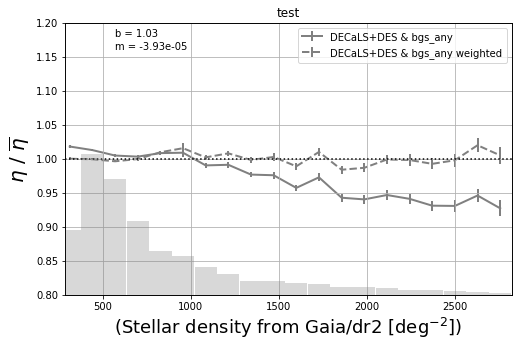

In [17]:
#
if reg[:8] == 'svfields': reg_ = reg+'_'+survey[0]
else: reg_ = reg

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20

b0, m0 = plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[reg_], syst='stardens', mainreg=isdesi, 
                      xlim=None, n=0, nx=nx, clip=True, denslims=False, ylab=True, weights=True, 
                          fig=fig, gs=gs, title='test', label=True)

In [49]:
#dic WEIGHTED

ws = 1./((m0)*hpdict['stardens'] + b0)

hpdict_ws = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels={'bgs_any':20, 'bright':21, 'faint':22}, 
                                  galb=cat_ex['b'], log=True, survey='bgs', ws=ws)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68230483
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_any
computing for  north / bright
computing for  north / faint
target densities in north DONE...
computing for  south / bgs_any
computing for  south / bright
computing for  south / faint
target densities in south DONE...
meandens_bgs_any_all = 1398 /deg2
meandens_bgs_any_des = nan /deg2
meandens_bgs_any_decals = nan /deg2
meandens_bgs_any_north = 1398 /deg2
meandens_bgs_any_south = nan /deg2
meandens_bgs_any_svfields = 1370 /deg2
meandens_bgs_any_svfields_n = 1370 /deg2
meandens_bgs_any_svfields_s = nan /deg2
meandens_bright_all = 824 /deg2
meandens_bright_des = nan /deg2
meandens_bright_decals = nan /deg2
meandens_bright_north = 824 /deg2
meandens_bright_south = nan /deg2
meandens_bright_svfields = 798 /deg2
meandens_bright_svfields_n = 798 /deg2
meandens_bright_svfields_s = nan /deg2
meandens_faint_all = 574 /

In [18]:
from QA import pixhistregs

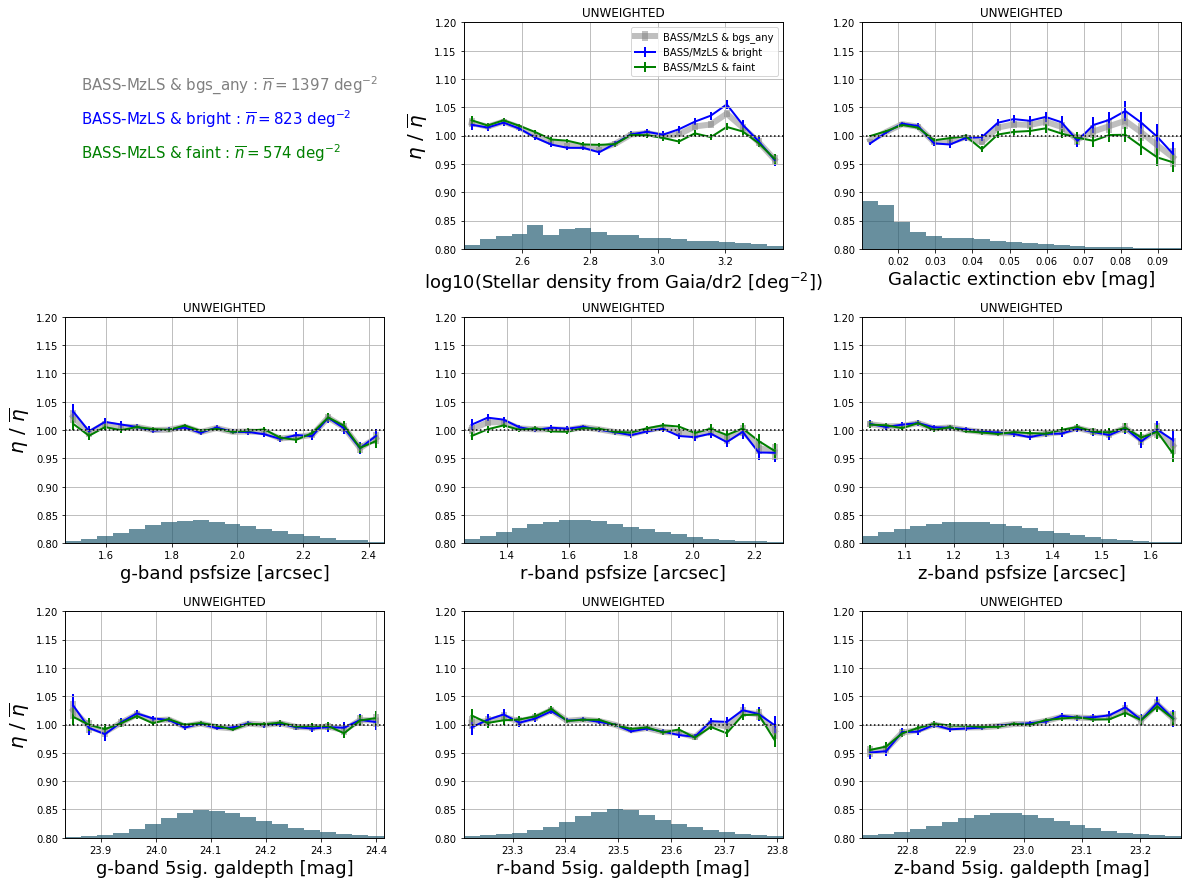

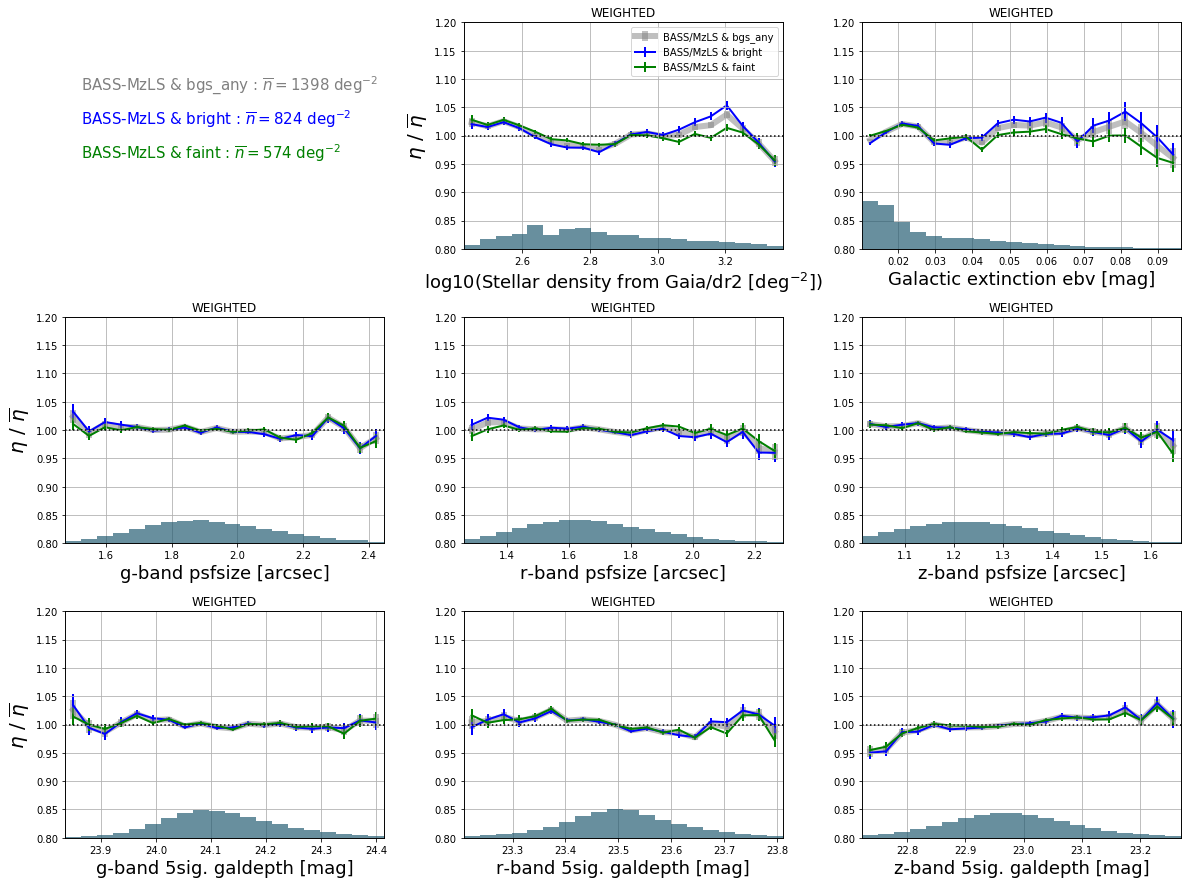

In [51]:
# dr8_south+north : density distributions + systematics

# settings
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['0.5','b','g','r']    
#regs = [reg]
namesels=['bgs_any', 'bright', 'faint']
#

# looping on subselections
#for key, title in zip([None, ws], ['UNWEIGHTED', 'WEIGHTED']):
for key, title in zip([hpdict, hpdict_ws], ['UNWEIGHTED', 'WEIGHTED']):
    
    # systematics
    fig    = plt.figure(figsize=(20,15))
    gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)
        
    for i in range(len(systs)+1):
        
        if i == 0:
            axinfo = fig.add_subplot(gs[i])
            # infos
            axinfo.axis('off')
            #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
            tmpy = 0.7
            #for regi,col in zip(regs,cols):
            #if reg == 'south':reg_ = 'DECaLS+DES'
            #else: reg_ = reg
            for namesel,col in zip(namesels,cols):
                tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%key['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
                axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
                tmpy  -= 0.15
        else:
            syst = systs[i-1]
            if (i%3==0) or (i==1): ylab=True
            else: ylab = False
            if i == 1: label = True
            else: label = False
            #if title == 'UNWEIGHTED': 
            #    weights = False
            #    onlyweights=False
            #else: 
            #    weights = True
            #    onlyweights=True
                
            plot_sysdens(hpdicttmp=key, namesels=namesels, regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                         denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=title, 
                             ws=None)
    
    # save fig
    fig.savefig('%s/systematics_main_bgs_%s_%s.png' %(pathdir, survey, title), bbox_inches = 'tight', pad_inches = 0)
    print('')
    print('')

### Systematics with and withouth MS masking

In [28]:
bgs_MS = ((cat['BGSBITS'] & 2**(1)) != 0)
MS = ((cat['MASKBITS'] & 2**11)==0)
Ared = hpdict['bgsarea_'+reg]

namesels = {'bgs':bgs_any,
            'bgs & ~MS':((bgs_any) & (MS)), #BGS applying MS mask
            'bgs & ~MS & LG':((bgs_any) & (bgs_MS))} #BGS applying MS mask but without masking the large galaxies (except for LG around BS and GC)

for key, val in zip(namesels.keys(), namesels.values()):
    print('%s: \t %.2f (objects/sq.deg)' %(key, np.sum(val)/Ared))


bgs: 	 1393.85 (objects/sq.deg)
bgs & ~MS: 	 1374.42 (objects/sq.deg)
bgs & ~MS & LG: 	 1374.71 (objects/sq.deg)


In [29]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['MS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68230483
bgsfracarea DONE...
regions DONE...
area_all = 4325 deg2
bgsarea_south = 0 deg2
bgsarea_decals = 0 deg2
bgsarea_des = 0 deg2
bgsarea_north = 4325 deg2
bgsarea_south_n = 0 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 193 deg2
bgsarea_svfields_n = 193 deg2
bgsarea_svfields_s = 0 deg2
bgsarea_svfields_fg = 92 deg2
bgsarea_svfields_fg_n = 92 deg2
bgsarea_svfields_fg_s = 0 deg2
bgsarea_svfields_ij = 53 deg2
bgsarea_svfields_ij_n = 53 deg2
bgsarea_svfields_ij_s = 0 deg2
areas DONE...
computing for  north / bgs
computing for  north / bgs & ~MS
computing for  north / bgs & ~MS & LG
target densities in north DONE...
computing for  south / bgs
computing for  south / bgs & ~MS
computing for  south / bgs & ~MS & LG
target densities in south DONE...
meandens_bgs_all = 1421 /deg2
meandens_bgs_south = nan /deg2
meandens_bgs_decals = nan /deg2
meandens_bgs_des = nan /deg2
meandens_bgs_north = 1421 /

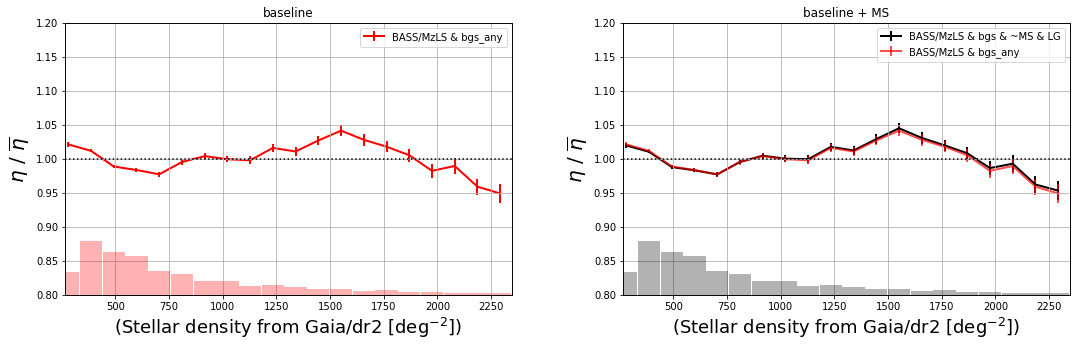

In [30]:
#
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0) #this should be rename as "mainreg"
nx         = 20
cols       = ['r','b','g','r']

x, y, yerr, lab = plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any'], regs=[reg_], syst='stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                     denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='baseline', label=True, ws=None, cols=['r'], overbyreg=False, get_values=True)

ax = plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs & ~MS & LG'], regs=[reg_], syst='stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                     denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='baseline + MS', label=True, ws=None, cols=['k'], overbyreg=False)

ax.errorbar(x, y, yerr, color='r',ecolor='r',zorder=1,lw=2,alpha=0.7, label=lab)
ax.legend()


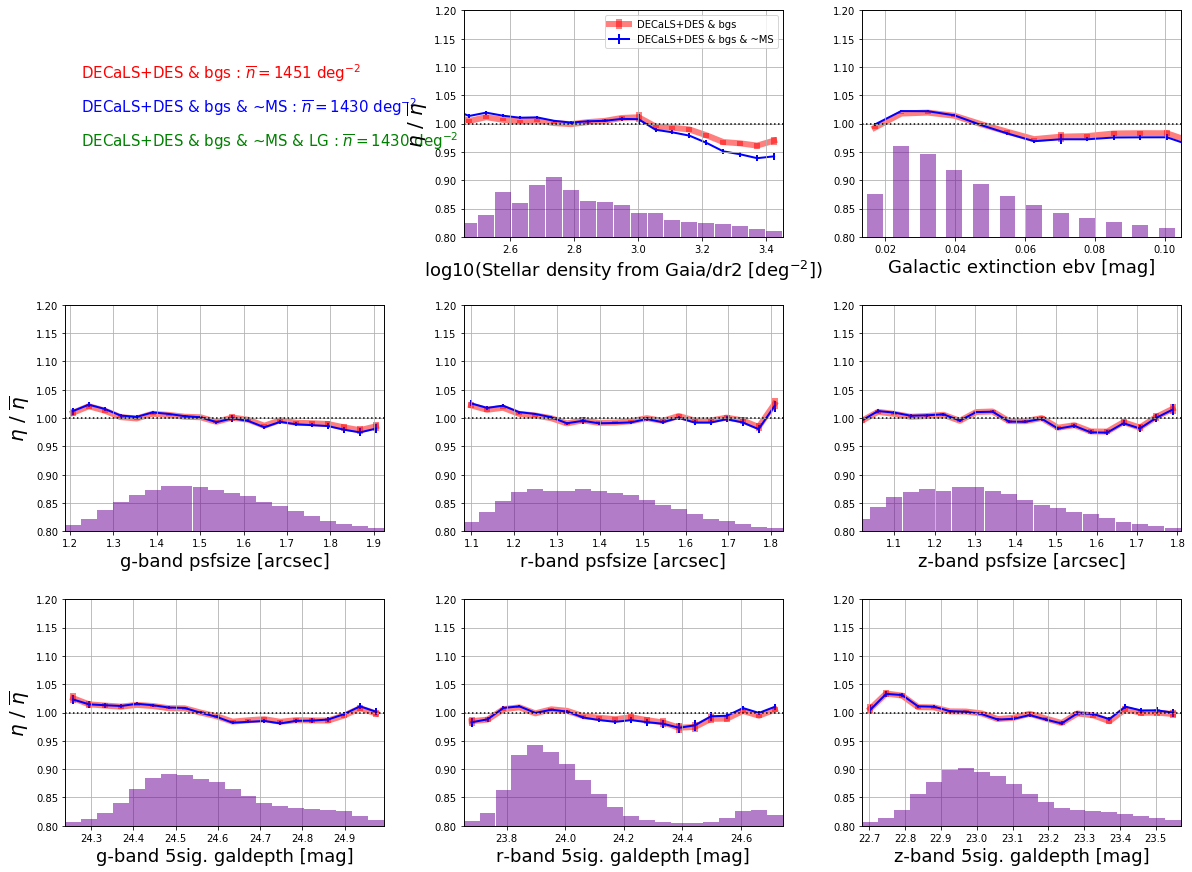

In [27]:
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['r','b','g','r']    
    
# systematics
fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)

for i in range(len(systs)+1):

    if i == 0:
        axinfo = fig.add_subplot(gs[i])
        # infos
        axinfo.axis('off')
        #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
        tmpy = 0.7
        #for regi,col in zip(regs,cols):
        #if reg == 'south':reg_ = 'DECaLS+DES'
        #else: reg_ = reg
        for namesel,col in zip(namesels,cols):
            tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict_tmp['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
            axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
            tmpy  -= 0.15
    else:
        syst = systs[i-1]
        if (i%3==0) or (i==1): ylab=True
        else: ylab = False
        if i == 1: label = True
        else: label = False
        #if title == 'UNWEIGHTED': 
        #    weights = False
        #    onlyweights=False
        #else: 
        #    weights = True
        #    onlyweights=True

        plot_sysdens(hpdicttmp=hpdict_tmp, namesels=list(namesels.keys())[:-1], regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                     denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=None, 
                         ws=None, cols=cols, overbyreg=False)

# save fig
fig.savefig('%s/systematics_MS_comparison_%s_%s.png' %(pathdir, survey, 'unweighted'), bbox_inches = 'tight', pad_inches = 0)

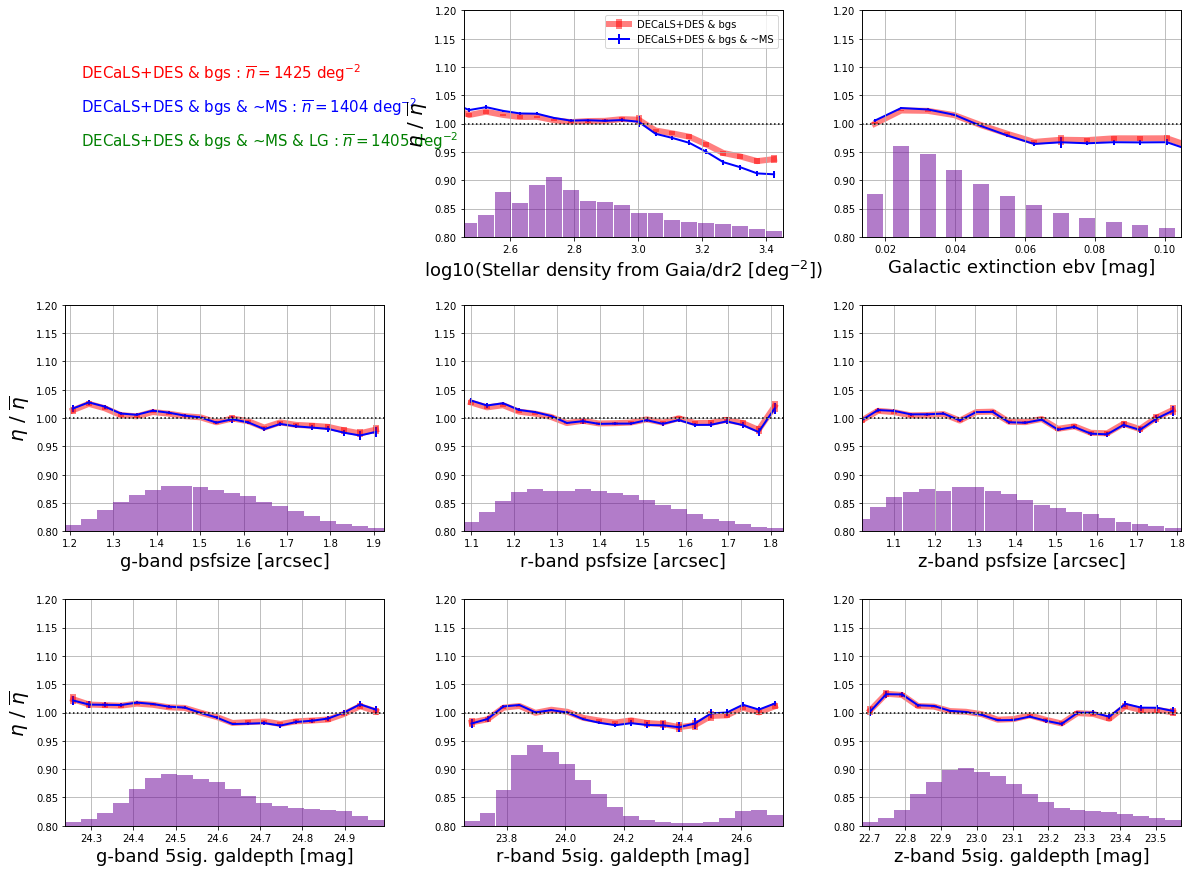

In [25]:
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0) #this should be rename as "mainreg"
systs      = ['log10_stardens','ebv','psfsize_g', 'psfsize_r', 'psfsize_z','galdepth_g', 'galdepth_r', 'galdepth_z']
nx         = 20
cols       = ['r','b','g','r']    
    
# systematics
fig    = plt.figure(figsize=(20,15))
gs     = gridspec.GridSpec(3,3,hspace=0.30,wspace=0.25)

for i in range(len(systs)+1):

    if i == 0:
        axinfo = fig.add_subplot(gs[i])
        # infos
        axinfo.axis('off')
        #axinfo.text(0.5,0.9,namesel,fontsize=20,fontweight='bold',ha='center',transform=axinfo.transAxes)
        tmpy = 0.7
        #for regi,col in zip(regs,cols):
        #if reg == 'south':reg_ = 'DECaLS+DES'
        #else: reg_ = reg
        for namesel,col in zip(namesels,cols):
            tmpstr = surveylab+' & '+namesel+' : '+r'$\overline{n}=$'+'%.0f'%hpdict_tmp['meandens_'+namesel+'_'+reg]+r' deg$^{-2}$'
            axinfo.text(0.05,tmpy,tmpstr,color=col,fontsize=15,transform=axinfo.transAxes)
            tmpy  -= 0.15
    else:
        syst = systs[i-1]
        if (i%3==0) or (i==1): ylab=True
        else: ylab = False
        if i == 1: label = True
        else: label = False
        #if title == 'UNWEIGHTED': 
        #    weights = False
        #    onlyweights=False
        #else: 
        #    weights = True
        #    onlyweights=True

        plot_sysdens(hpdicttmp=hpdict_tmp, namesels=list(namesels.keys())[:-1], regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=i, nx=nx, clip=True, 
                     denslims=False, ylab=ylab, weights=False, fig=fig, gs=gs, label=label, title=None, 
                         ws=None, cols=cols)

# save fig
fig.savefig('%s/systematics_MS_comparison_%s_%s.png' %(pathdir, survey, 'unweighted'), bbox_inches = 'tight', pad_inches = 0)

### Systematics separated by best model fitted

In [19]:
namesels = {}
for i in ['COMP', 'DEV ', 'EXP ', 'PSF ', 'REX ']:
    namesels[i] = (cat['TYPE'] == i) & (bgs_any)

In [20]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / COMP
computing for  north / DEV 
computing for  north / EXP 
computing for  north / PSF 
computing for  north / REX 
target densities in north DONE...
computing for  south / COMP
computing for  south / DEV 
computing for  south / EXP 
computing for  south / PSF 
computing for  south / REX 
target densities in south DONE...
meandens_COMP_all = 31 /deg2
meandens_COMP_des = 50 /deg2
meandens_COMP_decals = 28 /deg2
meandens_COMP_north = nan /deg2
meandens_COMP_south = 31 /deg2
meandens_COMP_svfields = 34 /deg2
meandens_COMP_svfields_n = nan /deg2
meandens_COMP_svfields_s = 34 /deg2
meandens_DEV _all = 630 /deg2
meandens_DEV _des = 650 /deg2
meandens_DEV _decals = 627 /deg2
meandens_DEV _north = nan /deg2
meandens_DEV _south = 630 /deg2
meandens_DEV _svfields = 655 /deg2
meandens_DEV _svfields_n = nan /deg2
meandens_DEV

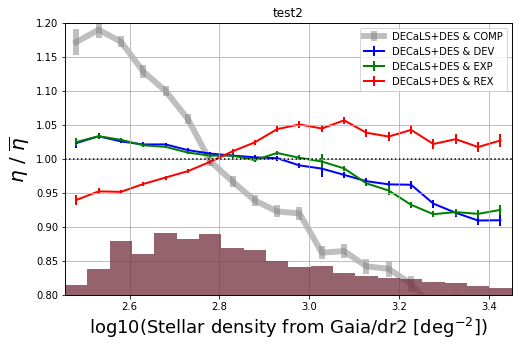

In [27]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['COMP', 'DEV ', 'EXP ', 'REX '], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

### Systematics separated by rmag bins

In [30]:
namesels = {}
mags = np.linspace(16, 20, 9)
for i in range(len(mags[:-1])):
    namesels['%s_%s' %(str(mags[i]), str(mags[i+1]))] = (cat['RMAG'] > mags[i]) & (cat['RMAG'] < mags[i+1]) & (bgs_any)

In [31]:
namesels.keys()

dict_keys(['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0', '18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'])

In [32]:
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=cat_ex['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / 16.0_16.5
computing for  north / 16.5_17.0
computing for  north / 17.0_17.5
computing for  north / 17.5_18.0
computing for  north / 18.0_18.5
computing for  north / 18.5_19.0
computing for  north / 19.0_19.5
computing for  north / 19.5_20.0
target densities in north DONE...
computing for  south / 16.0_16.5
computing for  south / 16.5_17.0
computing for  south / 17.0_17.5
computing for  south / 17.5_18.0
computing for  south / 18.0_18.5
computing for  south / 18.5_19.0
computing for  south / 19.0_19.5
computing for  south / 19.5_20.0
target densities in south DONE...
meandens_16.0_16.5_all = 12 /deg2
meandens_16.0_16.5_des = 12 /deg2
meandens_16.0_16.5_decals = 12 /deg2
meandens_16.0_16.5_north = nan /deg2
meandens_16.0_16.5_south = 12 /deg2
meandens_16.0_16.5_svfields = 11 /deg2
meandens_16.0_16.5_svfields_n = nan 

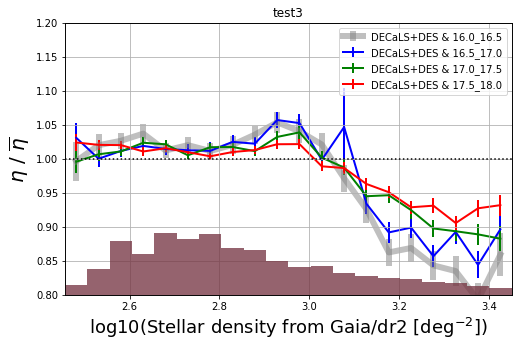

In [33]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['16.0_16.5', '16.5_17.0', '17.0_17.5', '17.5_18.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test3', label=True)

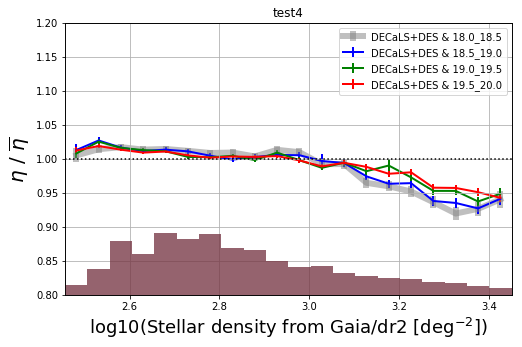

In [34]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['18.0_18.5', '18.5_19.0', '19.0_19.5', '19.5_20.0'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test4', label=True)

# Skymap footprint
Below code only needs the randoms.

area_all: 	 20332.475(whole) 	 14265.679(desifootprint)
bgsarea_south: 	 15173.940(whole) 	 9716.980(desifootprint)
bgsarea_north: 	 5158.535(whole) 	 4548.699(desifootprint)
bgsarea_des: 	 5060.633(whole) 	 1113.520(desifootprint)
NGC DECaLS in DESI footprint: 	 5322.602
SGC DECaLS in DESI footprint: 	 4394.378


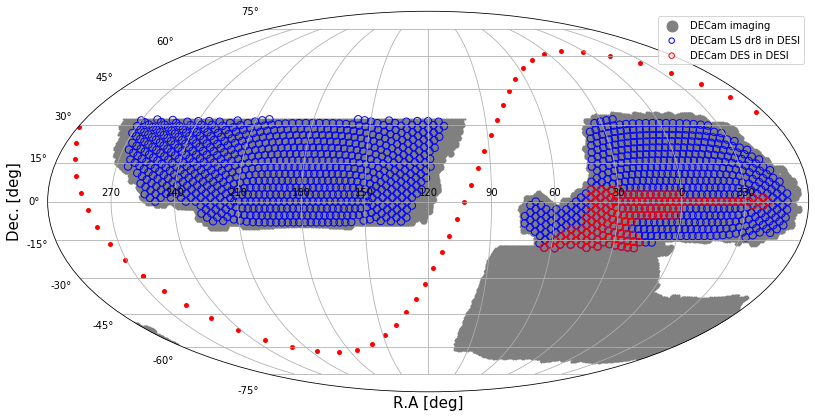

In [5]:
#
from QA import set_mwd, get_radec_mw
from io_ import get_isdes

# dict without geometrical mask and in WHOLE SWEEPS footprint
hpdict0 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=False, namesels=None, target_outputs=False, log=False)
# dict without geometrical mask and in DESI footprint
hpdict1 = get_dict(cat=None, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=False)

#
for i in ['area_all', 'bgsarea_south', 'bgsarea_north', 'bgsarea_des']:
    print('%s: \t %.3f(whole) \t %.3f(desifootprint)' %(i, hpdict0[i], hpdict1[i]))
    
if survey == 'south':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_decals_ngc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    area_decals_sgc = hpdict1['bgsfracarea'][(hpdict1['issouth']) & (hpdict1['galb'] < 0)].sum() * pixarea
    print('NGC DECaLS in DESI footprint: \t %.3f' %(area_decals_ngc))
    print('SGC DECaLS in DESI footprint: \t %.3f' %(area_decals_sgc))
    
if survey == 'north':
    # DECaLS area in the NGC/SGC within DESI footprint
    area_bass_ngc = hpdict1['bgsfracarea'][(hpdict1['isnorth']) & (hpdict1['galb'] > 0)].sum() * pixarea
    print('NGC BASS/MzLS in DESI footprint: \t %.3f' %(area_bass_ngc))

desitiles = fitsio.read('/global/homes/q/qmxp55/desi-tiles-viewer.fits')
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'

# plotting bgsfracarea
fig = plt.figure(figsize=(14, 7))
gs = gridspec.GridSpec(1,1,wspace=0.15,hspace=0)

ax = plt.subplot(gs[0],projection=projection)
_ = set_mwd(ax,org=org)
ramw,decmw = get_radec_mw(hpdict0['ra'],hpdict0['dec'],org)
tmp        = (hpdict0['bgsfracarea']>0) & (hpdict0['is'+survey])
if survey == 'south':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'DECam imaging')
if survey == 'north':
    SC         = ax.scatter(ramw[tmp],decmw[tmp],s=0.4, color='gray', label=r'BASS/MzLS imaging')

ramw,decmw = get_radec_mw(desitiles['ra'],desitiles['dec'],org)
if survey == 'south':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'DECam LS dr8 in DESI')
if survey == 'north':
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] > dec_resol_ns)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='blue', label=r'BASS/MzLS dr8 in DESI')


if survey == 'south':
    desitilesindes = get_isdes(desitiles['ra'],desitiles['dec'])
    tmp = (desitiles['in_desi'] ==  1) & (desitiles['dec'] < dec_resol_ns) & (desitilesindes)
    SC         = ax.scatter(ramw[tmp],decmw[tmp], marker='.', s = 220, facecolors='none', edgecolors='red', label=r'DECam DES in DESI')

gc = SkyCoord(l=np.linspace(0, 360, 50)*units.degree, b=np.full(50, 0)*units.degree, frame='galactic')
ramw,decmw = get_radec_mw(gc.icrs.ra.value, gc.icrs.dec.value,org)
SC         = ax.scatter(ramw, decmw, color='r', marker='.', lw=2)

lgnd = ax.legend()
[handle.set_sizes([120.0]) for handle in lgnd.legendHandles]

fig.savefig('%s/skyplot_%s.png' %(pathdir, survey), bbox_inches = 'tight', pad_inches = 0)


## get area by number of passes + skymap of regions

In [7]:
# get the area covered by the number of passes from 1 to 3 and per band and for the joint bands.
Apasses = {}
for i in [0, 1, 2]:
    for j in ['G', 'R', 'Z', 'all']:
        
        if j == 'all': mask = (ran['NOBS_G'] > i) & (ran['NOBS_R'] > i) & (ran['NOBS_Z'] > i)
        else: mask = (ran['NOBS_'+j] > i)
            
        hpdicttest = get_dict(pixmapfile=dr8pix, hppix_ran=hppix_ran, maskrand=mask, Nranfiles=Nranfiles, 
                              ranindesi=ranindesi, desifootprint=True, target_outputs=False)
        
        for k in ['south', 'north', 'decals', 'des']:
            Apasses[j+str(i+1)+'_'+k] = hpdicttest['bgsarea_'+k]
        Apasses[j+str(i+1)+'_'+'all'] = hpdicttest['area_all']
            
        print('%s >= %i: \t south: %2.3g, north: %2.3g, decals: %2.3g, des: %2.3g, all: %2.3g' 
              %(j, i+1, hpdicttest['bgsarea_south'], hpdicttest['bgsarea_north'], hpdicttest['bgsarea_decals'], 
                    hpdicttest['bgsarea_des'], hpdicttest['area_all']))

G >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
R >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
Z >= 1: 	 south: 9.69e+03, north: 4.54e+03, decals: 8.57e+03, des: 1.11e+03, all: 1.42e+04
all >= 1: 	 south: 9.67e+03, north: 4.52e+03, decals: 8.56e+03, des: 1.11e+03, all: 1.42e+04
G >= 2: 	 south: 9.45e+03, north: 4.49e+03, decals: 8.34e+03, des: 1.11e+03, all: 1.39e+04
R >= 2: 	 south: 9.42e+03, north: 4.49e+03, decals: 8.31e+03, des: 1.11e+03, all: 1.39e+04
Z >= 2: 	 south: 9.49e+03, north: 4.49e+03, decals: 8.37e+03, des: 1.11e+03, all: 1.4e+04
all >= 2: 	 south: 9.26e+03, north: 4.41e+03, decals: 8.15e+03, des: 1.11e+03, all: 1.37e+04
G >= 3: 	 south: 7.77e+03, north: 3.93e+03, decals: 6.66e+03, des: 1.11e+03, all: 1.17e+04
R >= 3: 	 south: 7.57e+03, north: 3.9e+03, decals: 6.46e+03, des: 1.11e+03, all: 1.15e+04
Z >= 3: 	 south: 8.04e+03, north: 3.89e+03, decals: 6.93e+03, des: 1.11e+03, all: 1.19e+

In [8]:
#
print('BAND \t >= 1 \t\t >= 2 \t\t >= 3')
print('------------------------------------------')
for band in ['G', 'R', 'Z', 'all']:
    lab1 = band+'1'+'_south'
    lab2 = band+'2'+'_south'
    lab3 = band+'3'+'_south'
    
    print('%s: \t %.0f \t %.0f \t %.0f' %(band, Apasses[lab1], Apasses[lab2], Apasses[lab3]))


BAND 	 >= 1 		 >= 2 		 >= 3
------------------------------------------
G: 	 9687 	 9454 	 7769
R: 	 9686 	 9422 	 7569
Z: 	 9686 	 9487 	 8036
all: 	 9669 	 9257 	 6870


# DEV ZONE

In [68]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM','QC_FI','QC_FF','QC_IVAR', 'FMC2', 'CC', 'nobs', 'BS', 'LG', 'GC'], bgsmask=bgsmask(), rlimit=20.7)
#bgsbutCC = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['CC'], bgsmask=bgsmask())
#bgsbutFMC2 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['FMC2'], bgsmask=bgsmask())
#bgsbutBSLG = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS', 'LG'], bgsmask=bgsmask())

In [43]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)

In [69]:
namesels = {}
#namesels['bgs_any'] = bgs_any
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [70]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=None,
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1452 /deg2
meandens_bgsbut20_des = 1442 /deg2
meandens_bgsbut20_decals = 1453 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1452 /deg2
meandens_bgsbut20_svfields = 1466 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1466 /deg2
meandens_bgsbut201_all = 1608 /deg2
meandens_bgsbut201_des = 1596 /deg2
meandens_bgsbut201_decals = 1610 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1608 /deg2
meandens_bgsbut201_svfields =

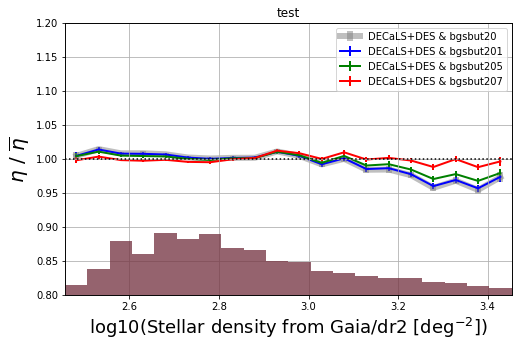

In [71]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [73]:
#bgslist = ['BS', 'LG', 'GC', 'nobs', 'FMC2', 'CC', 'QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR']
bgsbut20 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20)
bgsbut201 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.1)
bgsbut205 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.5)
bgsbut207 = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=None, bgsmask=bgsmask(), rlimit=20.7)

In [74]:
namesels = {}
namesels['bgsbut20'] = bgsbut20
namesels['bgsbut201'] = bgsbut201
namesels['bgsbut205'] = bgsbut205
namesels['bgsbut207'] = bgsbut207

In [75]:
#dic with default BGS selection and in DESI footprint
#maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs']))
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgsbut20
computing for  north / bgsbut201
computing for  north / bgsbut205
computing for  north / bgsbut207
target densities in north DONE...
computing for  south / bgsbut20
computing for  south / bgsbut201
computing for  south / bgsbut205
computing for  south / bgsbut207
target densities in south DONE...
meandens_bgsbut20_all = 1426 /deg2
meandens_bgsbut20_des = 1430 /deg2
meandens_bgsbut20_decals = 1425 /deg2
meandens_bgsbut20_north = nan /deg2
meandens_bgsbut20_south = 1426 /deg2
meandens_bgsbut20_svfields = 1437 /deg2
meandens_bgsbut20_svfields_n = nan /deg2
meandens_bgsbut20_svfields_s = 1437 /deg2
meandens_bgsbut201_all = 1578 /deg2
meandens_bgsbut201_des = 1583 /deg2
meandens_bgsbut201_decals = 1578 /deg2
meandens_bgsbut201_north = nan /deg2
meandens_bgsbut201_south = 1578 /deg2
meandens_bgsbut201_svfields =

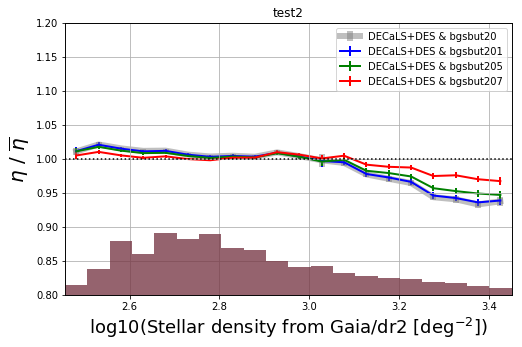

In [76]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)
isdesi     = (hpdict_tmp['isdesi']) & (hpdict_tmp['bgsfracarea']>0)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgsbut20', 'bgsbut201', 'bgsbut205', 'bgsbut207'], regs=[reg], 
                 syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=20, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test2', label=True)

#plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
#                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


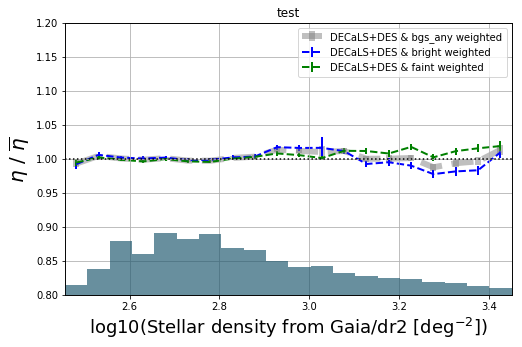

In [80]:
#
ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=True, fig=fig, gs=gs, title='test', label=True, ws=ws, onlyweights=True)

In [88]:
hpdict['meandens_bgs_any_south']

1425.646415390457

In [89]:
hpdict_tmp['meandens_bgs_any_south']

1432.660001909052

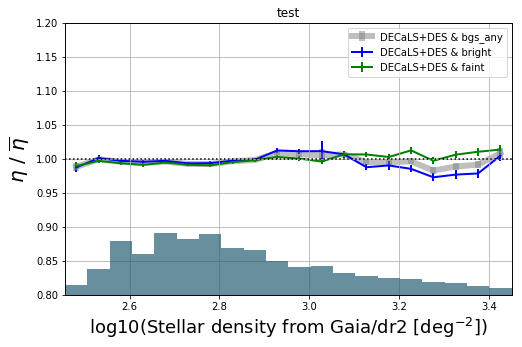

In [90]:
#
#ws = 1./((-3.96*10**(-5))*hpdict['stardens'] + 1.03)

fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_any', 'bright', 'faint'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True, ws=None, onlyweights=False)

In [53]:
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)
namesels = {}
mags = [15, 18, 18.5, 19.0, 19.5, 20.0]
for num,i in enumerate(mags[:-1]):
    namesels['bgs_%s_%s' %(str(mags[num]), str(mags[num+1]))] = (bgs_any) & (cat['RMAG'] > mags[num]) & (cat['RMAG'] < mags[num+1])
    

In [55]:
#dic with default BGS selection and in DESI footprint
hpdict_tmp = get_dict(cat=cat, pixmapfile=dr8pix, hppix_ran=hppix_ran, hppix_cat=hppix_cat, 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['LG']) & (rancuts['nobs'])),
                          maskcat=None, 
                             Nranfiles=Nranfiles, ranindesi=ranindesi, catindesi=None, 
                                desifootprint=True, namesels=namesels, galb=galb, log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  145754705
bgsfracarea DONE...
regions DONE...
areas DONE...
computing for  north / bgs_15_18
computing for  north / bgs_18_18.5
computing for  north / bgs_18.5_18.5
computing for  north / bgs_18.5_19.0
computing for  north / bgs_19.0_19.5
computing for  north / bgs_19.5_20.0
target densities in north DONE...
computing for  south / bgs_15_18
computing for  south / bgs_18_18.5
computing for  south / bgs_18.5_18.5
computing for  south / bgs_18.5_19.0
computing for  south / bgs_19.0_19.5
computing for  south / bgs_19.5_20.0
target densities in south DONE...
meandens_bgs_15_18_all = 154 /deg2
meandens_bgs_15_18_des = 153 /deg2
meandens_bgs_15_18_decals = 154 /deg2
meandens_bgs_15_18_north = nan /deg2
meandens_bgs_15_18_south = 154 /deg2
meandens_bgs_15_18_svfields = 151 /deg2
meandens_bgs_15_18_svfields_n = nan /deg2
meandens_bgs_15_18_svfields_s = 151 /deg2
meandens_bgs_18_18.5_all = 124 /deg2
meande

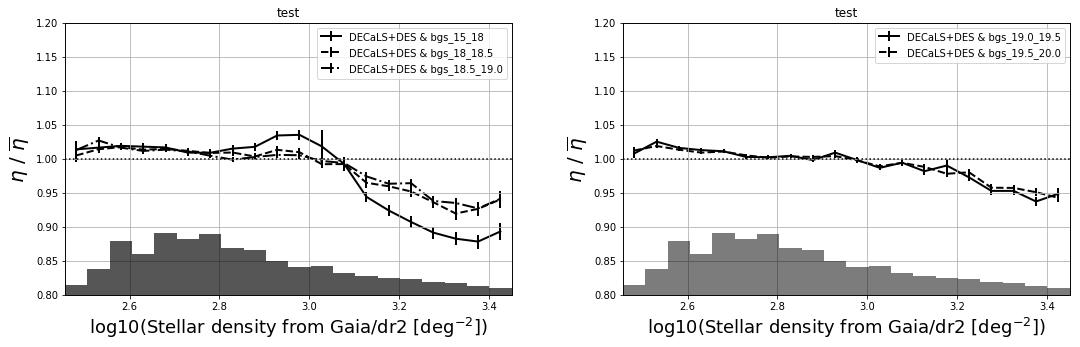

In [60]:
fig    = plt.figure(figsize=(18,5))
gs     = gridspec.GridSpec(1,2,hspace=0.30,wspace=0.25)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=['bgs_15_18', 'bgs_18_18.5', 'bgs_18.5_19.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=0, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)

plot_sysdens(hpdicttmp=hpdict_tmp, namesels=[ 'bgs_19.0_19.5', 'bgs_19.5_20.0'], regs=[reg], syst='log10_stardens', mainreg=isdesi, xlim=None, n=1, nx=nx, clip=True, 
                         denslims=False, ylab=True, weights=False, fig=fig, gs=gs, title='test', label=True)


In [ ]:
bgs_bright = ((cat['BGSBITS'] & 2**(21)) != 0)
bgs_faint = ((cat['BGSBITS'] & 2**(22)) != 0)
bgs_any = ((cat['BGSBITS'] & 2**(20)) != 0)